# CONTEXTE
* Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

* Pour accorder un crédit à la consommation, l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

* Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un client.

* Pour réaliser ce modèle, Michaël, votre manager, vous a fourni le jeu de données suivant qui contient :

    - un historique de prêts ;
    - un historique d’informations financières ;
    - des informations sur le comportement des emprunteurs (si l’emprunteur a fait défaut ou pas). 

* Après une première réunion de brief, Michaël vous a envoyé ce mail de récap :

De : Michaël / Envoyé : hier 17:14 / À : Vous 

Objet : Récap. Algo de scoring

Hello,

Merci pour notre meeting. Je souhaitais le compléter en te donnant quelques ressources :

- Pour aller plus vite sur la préparation des données, tu peux utiliser un **kernel Kaggle** (https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook). Par contre, fais attention à ce qu’il soit adapté à ton besoin. 
- Essaie notamment de **construire au moins trois nouvelles variables à partir des variables existantes** qui te semblent pertinentes pour améliorer le pouvoir prédictif du modèle. Essaie aussi de t’approprier le kernel au maximum en l’adaptant pour le projet.
- On a évoqué le fait que ton modèle doit être interprétable par les équipes qui vont l’utiliser. N’hésite pas à consulter ce site (https://towardsdatascience.com/interpretability-in-machine-learning-70c30694a05f) et ce GitHub (https://christophm.github.io/interpretable-ml-book/) à ce sujet. 
- Pense à **expliciter en quelques lignes la méthode d’importance des variables que tu retiendras**. Je souhaite une **analyse de l’importance des variables globale au modèle [le modèle que j'aurais dev], mais également locale pour un client donné [la même analyse pour un exemple client dans le dataset]**.
- Le modèle sera à présenter aux équipes, fais donc en sorte que ta présentation soit compréhensible par tous, et que ton Jupyter soit bien documenté. 
- **Pour les slides, je te suggère ce plan** :
    * Compréhension de la problématique métier.
    * Description du jeu de données.
    * Transformation du jeu de données (nettoyage et feature engineering).
    * Comparaison et synthèse des résultats pour les modèles utilisés.
    * Interprétabilité du modèle.
    * Conclusion.
        

* Concernant l’élaboration du modèle soit vigilant sur deux points spécifiques au contexte métier : 

    - Le déséquilibre entre le nombre de bons et de moins bons clients doit être pris en compte pour élaborer un modèle pertinent, à l’aide d’au moins une méthode au choix
    - Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge)
    - Tu pourras supposer, par exemple, que le coût d’un FN est dix fois supérieur au coût d’un FP
    - Tu créeras un score “métier” (minimisation du coût d’erreur de prédiction des FN et FP) pour comparer les modèles, afin de choisir le meilleur modèle et ses meilleurs hyperparamètres.
    - **Attention cette minimisation du coût métier doit passer par l’optimisation du seuil qui détermine, à partir d’une probabilité, la classe 0 ou 1 (un “predict” suppose un seuil à 0.5 qui n’est pas forcément l’optimum)**
    
**[ l'idée : rajouter en métrique d'évaluation des modèles, une fonction qui calcule le cout pour un FN et pour un FP, et l'utiliser pour sélectionner le meilleur modèle]**

En parallèle, maintiens pour comparaison et contrôle, des mesures plus techniques, telles que **l’AUC et l’accuracy**. 

D’autre part je souhaite que tu mettes en œuvre une démarche d’élaboration des modèles avec **Cross-Validation et optimisation des hyperparamètres, via GridsearchCV ou équivalent**.

Un dernier conseil : si tu obtiens des scores supérieurs au 1er du challenge Kaggle (AUC > 0.82), pose-toi la question si tu n’as pas de l’overfitting dans ton modèle !

Bon courage !

Michaël

Muni de toutes ces informations, vous vous mettez au travail ! 

# LIVRABLES

* Un Jupyter Notebook d'analyse exploratoire et de feature engineering
* Un Jupyter Notebook présentant les différentes parties de votre travail de modélisation :
    - Ces notebooks doivent pouvoir être utilisés par une autre personne, comme Michaël, par exemple. Leur présentation et leur structuration doivent donc être soignées afin que les notebooks puissent être pris en main par une personne autre que vous, sans que vous ayez à la former à leur utilisation.
* Une présentation (PowerPoint ou une alternative, sauvegardé au format pdf) :
    - Ce livrable vous servira à présenter votre approche méthodologique de modélisation de la problématique de scoring lors de la soutenance orale devant Michaël.

# IMPORTS

In [1]:
# data & science
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
import shap
import lime.lime_tabular 
# graphiques
import matplotlib.pyplot as plt
import seaborn as sns
# system & tools
import pickle
import os
import sys
from importlib import reload
import warnings
import time
from datetime import timedelta
warnings.filterwarnings('ignore')
#sys.path.insert(0, '/Users/stephanieduhem/Documents/MASTER_AI_ENGINEER/openclassroom/tools')
#import functions as fct




print(imblearn.__version__)

0.12.0


# FONCTIONS 

In [2]:
#### GRAPHIQUE CLASSIFICATION BINAIRE

def graph_conf_matrix_binary(confusion_matrix, subset) :
    # RECUPÉRATION DES POURCENTAGES POUR LES 4 CATEGORIES
    group_percentages = []
    for arr_val in confusion_matrix :
        for value in arr_val.flatten() :
            group_percentages.append(value/np.sum(arr_val)) 
    ax_= plt.subplot()
    # RÉCUPÉRATION ET MISE AU FORMAT DES NOMS, LABELS ET POURCENTAGES
    group_names = ['True_Neg','False_Pos','False_Neg','True_Pos']
    group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in group_percentages]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip (group_names, group_counts, group_percentages)]
    labels = np.array(labels).reshape(2,2)
    # GRAPHIQUE
    sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')
    ax_.set_xlabel('Predited labels')
    ax_.set_ylabel('True labels') 
    ax_.set_title(f'Confusion Matrix {subset}') 
    plt.show() 
    
#### GRAPHIQUE COURBE ROC ET SCORE AUC
  
def graph_roc_auc(y_true, y_predict_probas_test, model) :
    # RÉCUPÉRATION DES TAUX DE FAUX POSITIFS ET DE VRAIS POSITIFS
    [fpr, tpr, seuils] = metrics.roc_curve(y_true, y_predict_probas_test)
    auc = metrics.roc_auc_score(y_true, y_predict_probas_test)

    plt.plot(fpr, tpr, color='green', lw=2, label= f'{model} - auc = {round(auc,2)}')
    plt.plot([0, 1], [0, 1], ls = '--', lw=2, color='red', label='DummyClassifier - auc = 0,5')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs (1- spécificité) ', fontsize=11)
    plt.ylabel('Taux de Vrais Positifs (Sensibilité)', fontsize=11)
    plt.title('Courbe ROC')
    plt.grid(True)
    plt.legend()
    plt.show
    return fpr, tpr, auc 

# CHARGEMENT DES DONNÉES

In [3]:
# TRAIN DATA
data = pd.read_csv('final_data.csv')
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 139 entries, EXT_SOURCE_2 EXT_SOURCE_3 to TARGET
dtypes: bool(38), float64(83), int64(18)
memory usage: 248.1 MB
None


EXT_SOURCE_2 EXT_SOURCE_3  EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3  \
0                   0.036649                                0.003043   
1                   0.333073                                0.103675   
2                   0.405575                                0.205220   
3                   0.348166                                0.176171   
4                   0.172754                                0.087413   

   EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH  EXT_SOURCE_2^2 EXT_SOURCE_3  \
0                            346.733022                     0.009637   
1                           5583.975307                     0.207254   
2                           7724.580288                     0.225464   
3                           6616.894625                     0.226462   
4                           3443.335521                     0.055754   

   EXT_SOURCE_2 EXT_SOURCE_3^2  EXT_SOURCE_1 EXT_SOURCE_2  \
0                     0.005108                   0.021834   
1                     0.178286                   0.193685   
2                     0.295894                   0.281290   
3                     0.186365                   0.329122   
4                     0.092471                   0.163305   

   EXT_SOURCE_1 EXT_SOURCE_3  EXT_SOURCE_2  EXT_SOURCE_2 DAYS_BIRTH  \
0                   0.011573      0.262949              2487.756636   
1                   0.166614      0.622246             10431.950422   
2                   0.369159      0.555912             10587.901540   
3                   0.270849      0.650442             12361.644326   
4                   0.270849      0.322738              6432.819536   

   EXT_SOURCE_1 EXT_SOURCE_2^2  ...  REG_CITY_NOT_WORK_CITY  DAYS_ID_PUBLISH  \
0                     0.005741  ...                       0            -2120   
1                     0.120520  ...                       0             -291   
2                     0.156373  ...                       0            -2531   
3                     0.214075  ...                       0            -2437   
4                     0.052705  ...                       1            -3458   

   CODE_GENDER_M  DAYS_LAST_PHONE_CHANGE  NAME_INCOME_TYPE_Working  \
0           True                 -1134.0                      True   
1          False                  -828.0                     False   
2           True                  -815.0                      True   
3          False                  -617.0                      True   
4           True                 -1106.0                      True   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  DAYS_EMPLOYED_PERCENT  \
0                     2                            2              -0.067329   
1                     1                            1              -0.070862   
2                     2                            2              -0.011814   
3                     2                            2              -0.159905   
4                     2                            2              -0.152418   

   DAYS_EMPLOYED  TARGET  
0         -637.0       1  
1        -1188.0       0  
2         -225.0       0  
3        -3039.0       0  
4        -3038.0       0  

[5 rows x 139 columns]

In [4]:
Counter(data['TARGET'])

Counter({0: 282686, 1: 24825})

## PRÉPARATION DES DONNÉES

### TRAIN-TEST SPLIT

In [5]:
X = data[data.columns[:-1]].values
y = data['TARGET'].values

In [6]:
X_train, X_test, y_train, y_test = \
	model_selection.train_test_split(X, y,
                                	test_size=0.2 # 20% des données dans le jeu de test
                                	)

In [7]:
print('X_train.shape = ', X_train.shape, 'y_train.shape = ', y_train.shape, '\nX_test.shape = ', X_test.shape, 'y_test.shape = ', y_test.shape )

X_train.shape =  (246008, 138) y_train.shape =  (246008,) 
X_test.shape =  (61503, 138) y_test.shape =  (61503,)


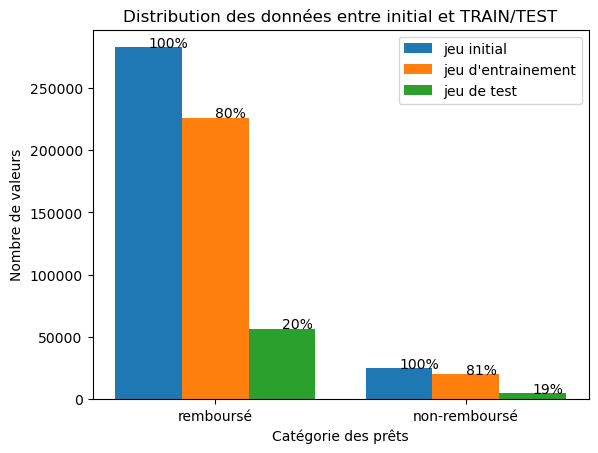

In [8]:
total_0 = data['TARGET'].value_counts()[0]
total_1 = data['TARGET'].value_counts()[1]

n, bins, patches = plt.hist([y, y_train, y_test], label=["jeu initial", "jeu d'entrainement", "jeu de test"], 
                            bins=np.arange(3) - 0.5)
plt.ylabel("Nombre de valeurs")
plt.xlabel("Catégorie des prêts")
plt.xticks([0, 1], labels=["remboursé", "non-remboursé"])
bin_centers = np.diff(bins)*0.5 + bins[:-1]

for patch in patches:
    width_0, height_0 = patch[0].get_width(), patch[0].get_height()
    x_text_0, y_text_0 = patch[0].get_xy()
    width_1, height_1 = patch[1].get_width(), patch[1].get_height()
    x_text_1, y_text_1 = patch[1].get_xy()
    plt.annotate("{:.0%}".format(height_0/total_0), xy = (x_text_0 + width_0/2 , y_text_0 + height_0 + 1.1))
    plt.annotate("{:.0%}".format(height_1/total_1), xy = (x_text_1 + width_1/2 , y_text_1 + height_1 + 1.1))

plt.title("Distribution des données entre initial et TRAIN/TEST")
plt.legend()


plt.show() 

* les classes sont déséquilibrées comme nous l'avions déjà vu.
* nous mettrons en place un pipeline avec une data augmentation par oversampling lorsque nous testerons les modèles. 

### MISE À L'ÉCHELLE

In [9]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_sc = std_scale.transform(X_train)
X_test_sc = std_scale.transform(X_test)
print('X_train_sc.shape = ', X_train_sc.shape, 'y_train.shape = ', y_train.shape, 
      '\nX_test_sc.shape = ', X_test_sc.shape, 'y_test.shape = ', y_test.shape )

X_train_sc.shape =  (246008, 138) y_train.shape =  (246008,) 
X_test_sc.shape =  (61503, 138) y_test.shape =  (61503,)


# MISE EN PLACE DU SCORE METIER

*  pour rappel
    - quand la target = 0 : le pret est remboursé 
    - quand la target = 1 : le pret est non remboursé 



      
* Le déséquilibre du coût métier entre un faux négatif (FN - mauvais client prédit bon client : donc crédit accordé et perte en capital) et un faux positif (FP - bon client prédit mauvais : donc refus crédit et manque à gagner en marge) doit être pris en compte afin de sélectionner le modèle le plus pertinent.

* Nous supposons donc pour ces premiers essais que le coût d’un FN est dix fois supérieur au coût d’un FP et nous allons batir un score métier en ce sens. 

* Évidemment cette proposition de coût métier devra être validée par le métier et modifiée au besoin.

* COUT MÉTIER = FN + 10*FP
* nous allons donc établir une matrice de cout correspondant à la matrice de confusion :

    - pour une matrice de confusion ainsi représentée [[TN, FP], [FN, TP]] 'True_Neg','False_Pos','False_Neg','True_Pos'

    - la matrice de cout métier sera donc ainsi :  [[0, 1], [10, 0]]


In [10]:
# Définir la fonction de coût métier
def cout_metier(y_true, y_pred):
    FN = np.sum((y_true == 1) & (y_pred == 0)) # faux négatif (mauvais client mis en bon client)
    FP = np.sum((y_true == 0) & (y_pred == 1)) # faux positif (bon client mis en mauvais client)
    return 10*FN + FP

# Créer un scorer personnalisé basé sur la fonction de coût métier à utiliser pour sélectionner les meilleurs lors des recherches par grille des hyperparamètres
score_metier = make_scorer(cout_metier, greater_is_better=False) #False car nous cherchons à obtenir la valeur la plus basse 


## MODELE NON LINÉAIRE : RandomForestClassifier

**RECHERCHE PAR GRILLE DES HYPERPARAMÈTRES**

In [11]:
# création d'un pipeline d'oversampling pour diminuer le déséquilibre entre les classes négatives et positives
pipeline_rf = Pipeline([('smote', SMOTE(random_state = 42, sampling_strategy='minority')),
     ('RandomForestClassifier', RandomForestClassifier(verbose = 1))
    ])

In [12]:
profondeurs = [2,3, 4, 5, 6, 7, 8]
param_grid_rf = {'RandomForestClassifier__max_depth' : profondeurs, 
                  'RandomForestClassifier__max_features' : ['sqrt', 'log2', None],
                  'RandomForestClassifier__criterion' : ['gini',
                                                         'entropy', 'log_loss'
                                                         ], 
                  'RandomForestClassifier__n_estimators' : [50, 100, 150 ],
                  'RandomForestClassifier__n_jobs' : [-1], 
                  'RandomForestClassifier__random_state' : [42],
                  #'smote__sampling_strategy' : ['minority', 'all', '0.70', '0.40' ],
                  'smote__k_neighbors' : [3, 5, 7, 9]
             }
# Créer un GridSearchCV avec le scorer personnalisé
grid_search_rf = GridSearchCV(estimator=pipeline_rf,
                           param_grid=param_grid_rf, 
                           scoring=score_metier, 
                           cv=5 #nombre de plis
                          )

In [14]:
####### X_train_sc.shape =  (246008, 137) y_train.shape =  (246008,) 
####### X_test_sc.shape =  (61503, 137) y_test.shape =  (61503,)
start = time.time()
grid_search_rf.fit(X_train_sc, y_train)
end = time.time()
duree = str(timedelta(seconds=(end-start)))
print('durée d\'entraîneemnt : ', duree)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]:

durée d'entraîneemnt :  5 days, 13:45:49.162567


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.9s finished


In [15]:
# les meilleurs hyoerparamètres
best_params_rf = grid_search_rf.best_params_
best_params_rf

{'RandomForestClassifier__criterion': 'gini',
 'RandomForestClassifier__max_depth': 5,
 'RandomForestClassifier__max_features': 'log2',
 'RandomForestClassifier__n_estimators': 100,
 'RandomForestClassifier__n_jobs': -1,
 'RandomForestClassifier__random_state': 42,
 'smote__k_neighbors': 3}

In [16]:
# avec le meilleur modèle prédiction sur le jeu de test # PREDICT SUR TEST (ancien 38572)
best_model_rf = grid_search_rf.best_estimator_
y_predict_test_rf = best_model_rf.predict(X_test_sc)
# évaluer le modèle sur le jeu de test avec la métrique personnalisée métier
test_score_metier_rf = cout_metier(y_test, y_predict_test_rf)
print('test_score_metier_rf = ', test_score_metier_rf)
# évaluer l'accuracy du modèle de classification
print("Test  Accuracy : ", best_model_rf.score(X_test_sc, y_test))
print("Train Accuracy : ", best_model_rf.score(X_train_sc, y_train))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


test_score_metier_rf =  34684
Test  Accuracy :  0.7094125489813505


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s


Train Accuracy :  0.7077412116679133


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.6s finished


{'RandomForestClassifier__max_depth': 4,
 'RandomForestClassifier__n_estimators': 100,
 'RandomForestClassifier__n_jobs': -1,
 'RandomForestClassifier__random_state': 42,
 'smote__k_neighbors': 3}
 
* les meilleurs hyperparamètres donnent un score métier sur le jeu de test égal à 35437.
* Regardons maintenant l'évolution du score en fonction du seuil

**RECHERCHE DU SEUIL DU SCORE MÉTIER LE PLUS BAS**

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


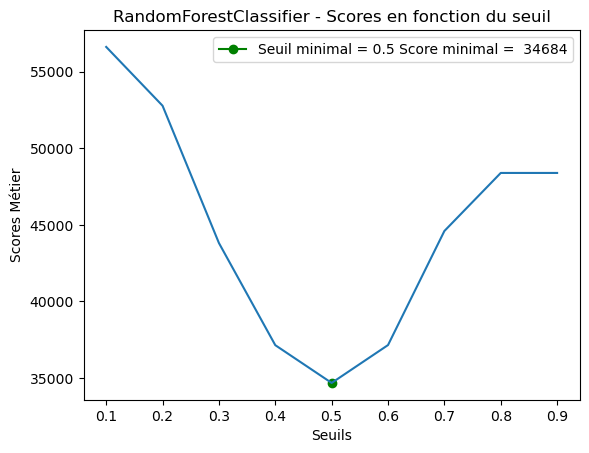

In [17]:
# prédictions des probabilités pour la classe positive avec les meilleurs hyperparamètres
probas_pred_test_rf = best_model_rf.predict_proba(X_test_sc)[:, 1] 
# définir les seuils
thresholds = np.arange(0.1, 1.0, 0.1)
# liste des scores
scores = [] 
# calculer les scores pour chaque seuil 
for threshold in thresholds:
        # récupération des proba de prédcitions positives par rapport à chaque valeur du seuil
        y_pred_test = (probas_pred_test_rf >= threshold).astype(int) 
        # Fonction de calcul du coût total
        score_ = cout_metier(y_test, y_pred_test)  
        scores.append(score_)

# récupérer le score minimal et son seuil associé pour l'afficher
score_min = min(scores)
seuil_min = thresholds[scores.index(score_min)]

# afficher le graphique
plt.plot(seuil_min, score_min, marker= 'o', color = 'green', 
         label= f'Seuil minimal = {round(seuil_min, 2)} Score minimal =  {score_min}')
plt.plot(thresholds, scores)
plt.xlabel('Seuils')
plt.ylabel('Scores Métier')
plt.title('RandomForestClassifier - Scores en fonction du seuil')
plt.legend()
plt.show()

* affinage du seuil


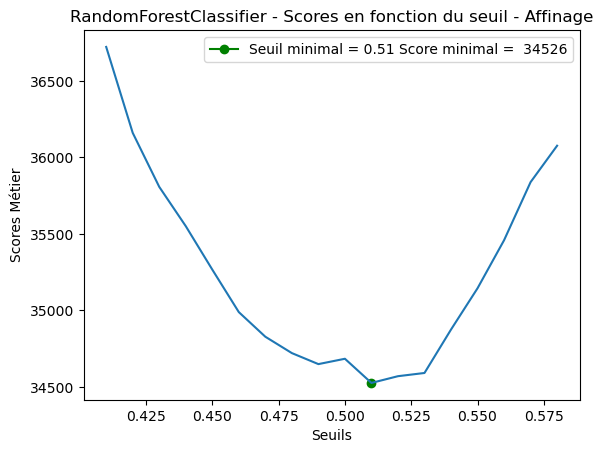

In [18]:
# définir les seuils
thresholds = np.arange(seuil_min-0.09, seuil_min+0.09, 0.01)
# liste des scores
scores = [] 
# calculer les scores pour chaque seuil 
for threshold in thresholds:
        # récupération des proba de prédcitions positives par rapport à chaque valeur du seuil
        y_pred_test = (probas_pred_test_rf >= threshold).astype(int) 
        # Fonction de calcul du coût total
        score_ = cout_metier(y_test, y_pred_test)  
        scores.append(score_)

# récupérer le score minimal et son seuil associé pour l'afficher
score_min_rf = min(scores)
seuil_min_rf = thresholds[scores.index(score_min_rf)]

# afficher le graphique
plt.plot(seuil_min_rf, score_min_rf, marker= 'o', color = 'green', 
         label= f'Seuil minimal = {round(seuil_min_rf, 2)} Score minimal =  {score_min_rf}')
plt.plot(thresholds, scores)
plt.xlabel('Seuils')
plt.ylabel('Scores Métier')
plt.title('RandomForestClassifier - Scores en fonction du seuil - Affinage')
plt.legend()
plt.show()

**ÉVALUATION DU CLASSIFIER POUR LE SEUIL MINIMAL**

* observons la matrice de confusion ainsi que la courbe ROC correspondant au score et seuil minimaux

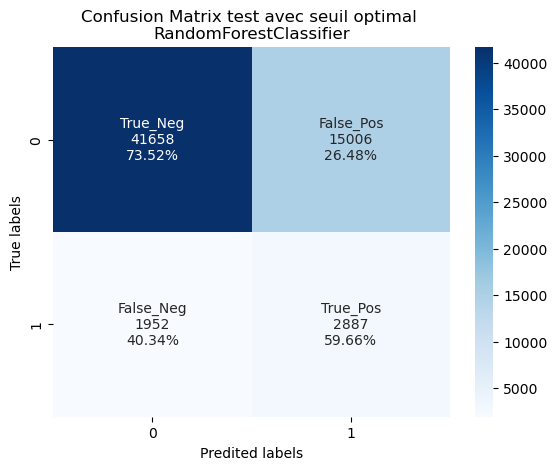

In [19]:
# predictions sur le jeu de test avec le seuil minimal
y_pred_test_opti_rf = (probas_pred_test_rf >= seuil_min_rf).astype(int) 
# matrice de confusion
c_m_test_opti_rf = confusion_matrix(y_test, y_pred_test_opti_rf)
graph_conf_matrix_binary(c_m_test_opti_rf, 'test avec seuil optimal \nRandomForestClassifier')

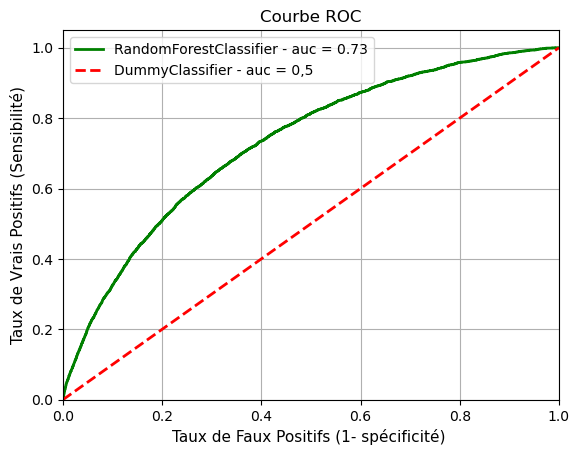

In [20]:
# courbe ROC et score AUC (qualité du classifier)
fpr_rf, tpr_rf, auc_rf  = graph_roc_auc(y_test, probas_pred_test_rf, 'RandomForestClassifier')

## MODÈLE LINÉAIRE  : Régression Logistique

**RECHERCHE PAR GRILLE DES HYPERPARAMÈTRES**

In [41]:
# création d'un pipeline d'oversampling pour diminuer le déséquilibre entre les classes négatives et positives
pipeline_reglog = Pipeline([('smote', SMOTE(random_state = 42, 
                                            sampling_strategy='minority'
                                            )),
     ('LogisticRegression', LogisticRegression(verbose = 1))
    ])

In [42]:
param_grid_rl = {'LogisticRegression__C' :[ 0.0001, 0.001, 0.01, 0.1, 1, 10 ],
                  'LogisticRegression__max_iter' : [ 25, 50, 100, 150],
                  'LogisticRegression__n_jobs' : [-1], 
                  'LogisticRegression__random_state' : [42],
                  #'smote__sampling_strategy' : ['minority', 'all', '0.70', '0.40' ],
                  'smote__k_neighbors' : [3, 5, 7, 9]
                 }
# Créer un GridSearchCV avec le scorer personnalisé
grid_search_rl = GridSearchCV(estimator=pipeline_reglog,
                           param_grid=param_grid_rl, 
                           scoring=score_metier, 
                           cv=5 #nombre de plis
                          )

In [43]:
####### X_train_sc.shape =  (246008, 137) y_train.shape =  (246008,) 
####### X_test_sc.shape =  (61503, 137) y_test.shape =  (61503,)
start = time.time()
grid_search_rl.fit(X_train_sc, y_train)
end = time.time()
duree = str(timedelta(seconds=(end-start)))
print('durée d\'entraîneemnt : ', duree)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.471D+01   2.105D+05
  F =   210537.87858825264     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   24.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   5.484D+01   2.105D+05
  F =   210508.36686254520     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   3.734D+01   2.104D+05
  F =   210441.26127373264     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.099D+01   2.104D+05
  F =   210444.10382287719     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.119D+01   2.103D+05
  F =   210272.58092179010     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.456D+01   2.106D+05
  F =   210594.61464123396     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.187D+01   2.106D+05
  F =   210551.01236569200     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   3.155D+01   2.098D+05
  F =   209794.22776343042     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   3.778D+01   2.100D+05
  F =   210006.29922344899     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.283D+01   2.097D+05
  F =   209731.29354336532     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.391D+01   2.101D+05
  F =   210080.13249348616     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.892D+01   2.104D+05
  F =   210355.32596077473     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.306D+01   2.102D+05
  F =   210153.74529342068     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   2.696D+01   2.100D+05
  F =   209993.20271598129     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   2.804D+01   2.100D+05
  F =   209994.46499032225     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   3.459D+01   2.102D+05
  F =   210196.90641697880     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.769D+01   2.104D+05
  F =   210377.94993521305     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.568D+01   2.100D+05
  F =   210006.10166985446     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   2.867D+01   2.097D+05
  F =   209747.89975796230     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.374D+01   2.095D+05
  F =   209530.46577872746     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     43      1     0     0   2.170D+00   2.105D+05
  F =   210537.69722388574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   1.754D+00   2.105D+05
  F =   210508.23553659458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     44      1     0     0   2.220D+00   2.104D+05
  F =   210441.13024351164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     44      1     0     0   1.763D+00   2.104D+05
  F =   210443.88871429893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   2.527D+00   2.103D+05
  F =   210272.38099320390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     42      1     0     0   3.112D+00   2.106D+05
  F =   210594.49073588851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   3.083D+00   2.106D+05
  F =   210550.87876949323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     42      1     0     0   1.619D+00   2.098D+05
  F =   209794.08700166372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   4.105D+00   2.100D+05
  F =   210006.10539351439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     44      1     0     0   1.363D+00   2.097D+05
  F =   209731.07900702528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     35     42      1     0     0   2.514D+00   2.101D+05
  F =   210080.03878111509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     43      1     0     0   2.050D+00   2.104D+05
  F =   210355.14608807955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   2.021D+00   2.102D+05
  F =   210153.61440538141     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     39     45      1     0     0   2.820D+00   2.100D+05
  F =   209993.08626096326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   1.307D+00   2.100D+05
  F =   209994.32669002432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     35     41      1     0     0   2.793D+00   2.102D+05
  F =   210196.80835217267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     43      1     0     0   3.115D+00   2.104D+05
  F =   210377.77771356478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   2.890D+00   2.100D+05
  F =   210005.91929166374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   2.341D+00   2.097D+05
  F =   209747.78449383454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     44      1     0     0   1.196D+00   2.095D+05
  F =   209530.31124001765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     43      1     0     0   2.170D+00   2.105D+05
  F =   210537.69722388574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   1.754D+00   2.105D+05
  F =   210508.23553659458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     44      1     0     0   2.220D+00   2.104D+05
  F =   210441.13024351164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     44      1     0     0   1.763D+00   2.104D+05
  F =   210443.88871429893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   2.527D+00   2.103D+05
  F =   210272.38099320390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     42      1     0     0   3.112D+00   2.106D+05
  F =   210594.49073588851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   3.083D+00   2.106D+05
  F =   210550.87876949323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     42      1     0     0   1.619D+00   2.098D+05
  F =   209794.08700166372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   4.105D+00   2.100D+05
  F =   210006.10539351439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     44      1     0     0   1.363D+00   2.097D+05
  F =   209731.07900702528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     35     42      1     0     0   2.514D+00   2.101D+05
  F =   210080.03878111509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     43      1     0     0   2.050D+00   2.104D+05
  F =   210355.14608807955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   2.021D+00   2.102D+05
  F =   210153.61440538141     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     39     45      1     0     0   2.820D+00   2.100D+05
  F =   209993.08626096326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   1.307D+00   2.100D+05
  F =   209994.32669002432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     35     41      1     0     0   2.793D+00   2.102D+05
  F =   210196.80835217267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     43      1     0     0   3.115D+00   2.104D+05
  F =   210377.77771356478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   2.890D+00   2.100D+05
  F =   210005.91929166374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   2.341D+00   2.097D+05
  F =   209747.78449383454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     44      1     0     0   1.196D+00   2.095D+05
  F =   209530.31124001765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     43      1     0     0   2.170D+00   2.105D+05
  F =   210537.69722388574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   1.754D+00   2.105D+05
  F =   210508.23553659458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     44      1     0     0   2.220D+00   2.104D+05
  F =   210441.13024351164     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     44      1     0     0   1.763D+00   2.104D+05
  F =   210443.88871429893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   2.527D+00   2.103D+05
  F =   210272.38099320390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     42      1     0     0   3.112D+00   2.106D+05
  F =   210594.49073588851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   3.083D+00   2.106D+05
  F =   210550.87876949323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     42      1     0     0   1.619D+00   2.098D+05
  F =   209794.08700166372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   4.105D+00   2.100D+05
  F =   210006.10539351439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     44      1     0     0   1.363D+00   2.097D+05
  F =   209731.07900702528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     35     42      1     0     0   2.514D+00   2.101D+05
  F =   210080.03878111509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     43      1     0     0   2.050D+00   2.104D+05
  F =   210355.14608807955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   2.021D+00   2.102D+05
  F =   210153.61440538141     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     39     45      1     0     0   2.820D+00   2.100D+05
  F =   209993.08626096326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   1.307D+00   2.100D+05
  F =   209994.32669002432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     35     41      1     0     0   2.793D+00   2.102D+05
  F =   210196.80835217267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     43      1     0     0   3.115D+00   2.104D+05
  F =   210377.77771356478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     37     42      1     0     0   2.890D+00   2.100D+05
  F =   210005.91929166374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     36     41      1     0     0   2.341D+00   2.097D+05
  F =   209747.78449383454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     38     44      1     0     0   1.196D+00   2.095D+05
  F =   209530.31124001765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.037D+02   2.083D+05
  F =   208340.71461202271     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.334D+02   2.082D+05
  F =   208243.87627308309     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.412D+02   2.081D+05
  F =   208108.53259397828     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.115D+02   2.082D+05
  F =   208153.85558692864     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.514D+02   2.080D+05
  F =   208015.61068951755     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.921D+02   2.084D+05
  F =   208376.79617011402     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.431D+02   2.083D+05
  F =   208286.83018233039     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.704D+02   2.075D+05
  F =   207450.84850292862     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.677D+02   2.077D+05
  F =   207708.41492867874     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.508D+02   2.074D+05
  F =   207430.30430657876     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.609D+02   2.079D+05
  F =   207878.10782270922     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.789D+02   2.081D+05
  F =   208126.32458789364     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.679D+02   2.078D+05
  F =   207758.77314620165     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.240D+02   2.077D+05
  F =   207666.20761984194     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.371D+02   2.078D+05
  F =   207759.16924938030     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   3.761D+02   2.080D+05
  F =   207971.47578011043     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.282D+02   2.081D+05
  F =   208109.64172760563     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.644D+02   2.076D+05
  F =   207632.56526078685     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   3.360D+02   2.074D+05
  F =   207403.21005900117     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   3.957D+02   2.072D+05
  F =   207223.55772169423     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.08256D+05    |proj g|=  5.24898D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   5.249D+01   2.083D+05
  F =   208256.04827238334     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04

At iterate   50    f=  2.08155D+05    |proj g|=  1.26162D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   1.262D+02   2.082D+05
  F =   208154.74302923199     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.08010D+05    |proj g|=  5.37231D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   5.372D+01   2.080D+05
  F =   208010.46076009618     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.08068D+05    |proj g|=  6.73756D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   6.738D+01   2.081D+05
  F =   208067.51893866906     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07931D+05    |proj g|=  6.33351D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   6.334D+01   2.079D+05
  F =   207930.86321674284     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.08297D+05    |proj g|=  5.71644D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   5.716D+01   2.083D+05
  F =   208297.23807704134     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.08215D+05    |proj g|=  6.14845D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   6.148D+01   2.082D+05
  F =   208214.66446699781     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.07359D+05    |proj g|=  5.57800D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   5.578D+01   2.074D+05
  F =   207359.01047628876     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.07619D+05    |proj g|=  1.78003D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   1.780D+02   2.076D+05
  F =   207618.78053654611     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.07347D+05    |proj g|=  7.03248D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   7.032D+01   2.073D+05
  F =   207346.83412177261     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.07784D+05    |proj g|=  5.06544D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   5.065D+01   2.078D+05
  F =   207784.36674566762     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.08043D+05    |proj g|=  5.86936D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   5.869D+01   2.080D+05
  F =   208043.41887308523     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.07672D+05    |proj g|=  6.20724D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   6.207D+01   2.077D+05
  F =   207671.96567891378     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.07575D+05    |proj g|=  6.54051D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   6.541D+01   2.076D+05
  F =   207574.88640549232     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.07670D+05    |proj g|=  5.61844D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   5.618D+01   2.077D+05
  F =   207670.25079300918     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.07886D+05    |proj g|=  5.71184D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   5.712D+01   2.079D+05
  F =   207886.19388170514     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.08032D+05    |proj g|=  9.56443D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     53      1     0     0   9.564D+01   2.080D+05
  F =   208032.13454634743     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.07538D+05    |proj g|=  1.34297D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   1.343D+02   2.075D+05
  F =   207537.86532497726     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.07313D+05    |proj g|=  6.88540D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   6.885D+01   2.073D+05
  F =   207312.58648348911     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.07138D+05    |proj g|=  6.80168D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   6.802D+01   2.071D+05
  F =   207137.94275362656     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.08256D+05    |proj g|=  5.24898D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     99    110      1     0     0   1.907D+00   2.083D+05
  F =   208253.69246866120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.08155D+05    |proj g|=  1.26162D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     99    109      1     0     0   4.210D+00   2.082D+05
  F =   208151.83697406901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.08010D+05    |proj g|=  5.37231D+01

At iterate  100    f=  2.08007D+05    |proj g|=  4.34620D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    113      1     0     0   4.346D+00   2.080D+05
  F =   208007.19349728106     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.08068D+05    |proj g|=  6.73756D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     98    108      1     0     0   2.414D+00   2.081D+05
  F =   208065.11135342318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07931D+05    |proj g|=  6.33351D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     92    101      1     0     0   2.210D+00   2.079D+05
  F =   207928.36333009030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.08297D+05    |proj g|=  5.71644D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     89     98      1     0     0   5.278D+00   2.083D+05
  F =   208294.82797447807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.08215D+05    |proj g|=  6.14845D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     88     97      1     0     0   8.961D+00   2.082D+05
  F =   208212.52987226690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.07359D+05    |proj g|=  5.57800D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     96    109      1     0     0   3.351D+00   2.074D+05
  F =   207356.47452802694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.07619D+05    |proj g|=  1.78003D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     89     96      1     0     0   1.461D+01   2.076D+05
  F =   207615.76628011162     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.07347D+05    |proj g|=  7.03248D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     98    109      1     0     0   2.994D+00   2.073D+05
  F =   207344.09496722906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.07784D+05    |proj g|=  5.06544D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     96    109      1     0     0   2.564D+00   2.078D+05
  F =   207781.43897394079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.08043D+05    |proj g|=  5.86936D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     97    107      1     0     0   2.270D+00   2.080D+05
  F =   208040.60170176605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.07672D+05    |proj g|=  6.20724D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     92    102      1     0     0   2.517D+00   2.077D+05
  F =   207669.85853613380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.07575D+05    |proj g|=  6.54051D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     93    102      1     0     0   2.257D+00   2.076D+05
  F =   207572.59496658453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.07670D+05    |proj g|=  5.61844D+01

At iterate  100    f=  2.07667D+05    |proj g|=  1.57623D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   1.576D+00   2.077D+05
  F =   207667.48239962323     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.07886D+05    |proj g|=  5.71184D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     93    105      1     0     0   4.368D+00   2.079D+05
  F =   207883.29189850550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.08032D+05    |proj g|=  9.56443D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     91     99      1     0     0   7.207D+00   2.080D+05
  F =   208029.93836860321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.07538D+05    |proj g|=  1.34297D+02

At iterate  100    f=  2.07534D+05    |proj g|=  3.15694D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    114      1     0     0   3.157D+00   2.075D+05
  F =   207534.45855673839     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.07313D+05    |proj g|=  6.88540D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     98    105      1     0     0   2.245D+00   2.073D+05
  F =   207309.54710141005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.07138D+05    |proj g|=  6.80168D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     96    107      1     0     0   3.715D+00   2.071D+05
  F =   207135.11046367703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.08256D+05    |proj g|=  5.24898D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     99    110      1     0     0   1.907D+00   2.083D+05
  F =   208253.69246866120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.08155D+05    |proj g|=  1.26162D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     99    109      1     0     0   4.210D+00   2.082D+05
  F =   208151.83697406901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.08010D+05    |proj g|=  5.37231D+01

At iterate  100    f=  2.08007D+05    |proj g|=  4.34620D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    113      1     0     0   4.346D+00   2.080D+05
  F =   208007.19349728106     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.08068D+05    |proj g|=  6.73756D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     98    108      1     0     0   2.414D+00   2.081D+05
  F =   208065.11135342318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07931D+05    |proj g|=  6.33351D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     92    101      1     0     0   2.210D+00   2.079D+05
  F =   207928.36333009030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.08297D+05    |proj g|=  5.71644D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     89     98      1     0     0   5.278D+00   2.083D+05
  F =   208294.82797447807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.08215D+05    |proj g|=  6.14845D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     88     97      1     0     0   8.961D+00   2.082D+05
  F =   208212.52987226690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04

At iterate   50    f=  2.07359D+05    |proj g|=  5.57800D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     96    109      1     0     0   3.351D+00   2.074D+05
  F =   207356.47452802694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.07619D+05    |proj g|=  1.78003D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     89     96      1     0     0   1.461D+01   2.076D+05
  F =   207615.76628011162     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    7.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.07347D+05    |proj g|=  7.03248D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     98    109      1     0     0   2.994D+00   2.073D+05
  F =   207344.09496722906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.07784D+05    |proj g|=  5.06544D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     96    109      1     0     0   2.564D+00   2.078D+05
  F =   207781.43897394079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04

At iterate   50    f=  2.08043D+05    |proj g|=  5.86936D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     97    107      1     0     0   2.270D+00   2.080D+05
  F =   208040.60170176605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.07672D+05    |proj g|=  6.20724D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     92    102      1     0     0   2.517D+00   2.077D+05
  F =   207669.85853613380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.07575D+05    |proj g|=  6.54051D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     93    102      1     0     0   2.257D+00   2.076D+05
  F =   207572.59496658453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.07670D+05    |proj g|=  5.61844D+01

At iterate  100    f=  2.07667D+05    |proj g|=  1.57623D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   1.576D+00   2.077D+05
  F =   207667.48239962323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.07886D+05    |proj g|=  5.71184D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     93    105      1     0     0   4.368D+00   2.079D+05
  F =   207883.29189850550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.08032D+05    |proj g|=  9.56443D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     91     99      1     0     0   7.207D+00   2.080D+05
  F =   208029.93836860321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.07538D+05    |proj g|=  1.34297D+02

At iterate  100    f=  2.07534D+05    |proj g|=  3.15694D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    103    117      1     0     0   5.332D+00   2.075D+05
  F =   207534.45641378989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.07313D+05    |proj g|=  6.88540D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     98    105      1     0     0   2.245D+00   2.073D+05
  F =   207309.54710141005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.07138D+05    |proj g|=  6.80168D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     96    107      1     0     0   3.715D+00   2.071D+05
  F =   207135.11046367703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.969D+02   2.079D+05
  F =   207894.92855509490     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.730D+02   2.078D+05
  F =   207776.63081877705     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   1.210D+03   2.076D+05
  F =   207589.78502590887     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.644D+02   2.077D+05
  F =   207685.44037344822     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.906D+02   2.076D+05
  F =   207563.83142403839     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.496D+02   2.079D+05
  F =   207924.59635859018     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.375D+02   2.078D+05
  F =   207831.61158906066     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     30      1     0     0   5.381D+02   2.069D+05
  F =   206929.57488654976     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.627D+02   2.072D+05
  F =   207226.88702911569     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.818D+02   2.070D+05
  F =   206970.58755638645     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.783D+02   2.074D+05
  F =   207418.60111182093     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   5.490D+02   2.077D+05
  F =   207663.12880283853     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.567D+02   2.072D+05
  F =   207237.99380130076     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.065D+02   2.072D+05
  F =   207181.32815601258     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.758D+02   2.073D+05
  F =   207309.31041593416     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.615D+02   2.075D+05
  F =   207519.76310192648     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   7.137D+02   2.076D+05
  F =   207645.73554437095     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.612D+02   2.071D+05
  F =   207098.84103574225     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.586D+02   2.069D+05
  F =   206915.48819638492     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.724D+02   2.067D+05
  F =   206746.85859670021     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07503D+05    |proj g|=  4.89817D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   4.898D+02   2.075D+05
  F =   207503.11584855718     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07416D+05    |proj g|=  2.60246D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   2.602D+02   2.074D+05
  F =   207415.58002922949     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07200D+05    |proj g|=  3.58126D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   3.581D+02   2.072D+05
  F =   207200.16978242010     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07290D+05    |proj g|=  2.90977D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   2.910D+02   2.073D+05
  F =   207289.74952793375     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07161D+05    |proj g|=  6.34391D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   6.344D+02   2.072D+05
  F =   207161.12874286488     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07561D+05    |proj g|=  4.91192D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   4.912D+02   2.076D+05
  F =   207561.18547517367     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07511D+05    |proj g|=  4.31902D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   4.319D+02   2.075D+05
  F =   207511.39812024459     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06582D+05    |proj g|=  2.17737D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   2.177D+02   2.066D+05
  F =   206581.56626668811     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06833D+05    |proj g|=  2.83526D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   2.835D+02   2.068D+05
  F =   206832.68116569330     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06564D+05    |proj g|=  3.25772D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   3.258D+02   2.066D+05
  F =   206564.44784072696     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.07031D+05    |proj g|=  2.26696D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   2.267D+02   2.070D+05
  F =   207030.74094629855     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07330D+05    |proj g|=  2.21454D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   2.215D+02   2.073D+05
  F =   207329.70875354356     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06860D+05    |proj g|=  2.71984D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   2.720D+02   2.069D+05
  F =   206859.90338247470     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06778D+05    |proj g|=  3.20345D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   3.203D+02   2.068D+05
  F =   206778.45044608568     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06928D+05    |proj g|=  3.84448D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     58      1     0     0   3.844D+02   2.069D+05
  F =   206928.12789043653     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.07124D+05    |proj g|=  3.38323D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   3.383D+02   2.071D+05
  F =   207124.02236838316     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07309D+05    |proj g|=  5.84126D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   5.841D+02   2.073D+05
  F =   207308.78894504849     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06721D+05    |proj g|=  2.80927D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     58      1     0     0   2.809D+02   2.067D+05
  F =   206721.03107815082     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06540D+05    |proj g|=  5.59045D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   5.590D+02   2.065D+05
  F =   206539.91158375470     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06356D+05    |proj g|=  2.45520D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   2.455D+02   2.064D+05
  F =   206355.83418254214     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07503D+05    |proj g|=  4.89817D+02

At iterate  100    f=  2.07340D+05    |proj g|=  1.23076D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    117      1     0     0   1.231D+02   2.073D+05
  F =   207340.48072042264     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07416D+05    |proj g|=  2.60246D+02

At iterate  100    f=  2.07248D+05    |proj g|=  9.07478D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   9.075D+01   2.072D+05
  F =   207248.03121669358     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07200D+05    |proj g|=  3.58126D+02

At iterate  100    f=  2.07045D+05    |proj g|=  1.04346D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   1.043D+02   2.070D+05
  F =   207045.49971490452     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07290D+05    |proj g|=  2.90977D+02

At iterate  100    f=  2.07109D+05    |proj g|=  1.75665D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   1.757D+02   2.071D+05
  F =   207109.12218750335     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07161D+05    |proj g|=  6.34391D+02

At iterate  100    f=  2.06993D+05    |proj g|=  9.57110D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    113      1     0     0   9.571D+01   2.070D+05
  F =   206992.60846127378     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07561D+05    |proj g|=  4.91192D+02

At iterate  100    f=  2.07415D+05    |proj g|=  1.36025D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   1.360D+02   2.074D+05
  F =   207415.46839448294     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07511D+05    |proj g|=  4.31902D+02

At iterate  100    f=  2.07366D+05    |proj g|=  1.24853D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    113      1     0     0   1.249D+02   2.074D+05
  F =   207365.79160977574     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06582D+05    |proj g|=  2.17737D+02

At iterate  100    f=  2.06414D+05    |proj g|=  2.19667D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    114      1     0     0   2.197D+02   2.064D+05
  F =   206413.64229295217     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06833D+05    |proj g|=  2.83526D+02

At iterate  100    f=  2.06662D+05    |proj g|=  2.24705D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    112      1     0     0   2.247D+02   2.067D+05
  F =   206662.23261022524     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06564D+05    |proj g|=  3.25772D+02

At iterate  100    f=  2.06389D+05    |proj g|=  1.15103D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   1.151D+02   2.064D+05
  F =   206389.08251816814     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.07031D+05    |proj g|=  2.26696D+02

At iterate  100    f=  2.06865D+05    |proj g|=  1.08014D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    113      1     0     0   1.080D+02   2.069D+05
  F =   206864.78081511878     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07330D+05    |proj g|=  2.21454D+02

At iterate  100    f=  2.07179D+05    |proj g|=  2.59419D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   2.594D+02   2.072D+05
  F =   207178.63880380892     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06860D+05    |proj g|=  2.71984D+02

At iterate  100    f=  2.06681D+05    |proj g|=  8.40388D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   8.404D+01   2.067D+05
  F =   206681.04131151651     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06778D+05    |proj g|=  3.20345D+02

At iterate  100    f=  2.06608D+05    |proj g|=  7.34191D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    108      1     0     0   7.342D+01   2.066D+05
  F =   206607.99692872562     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06928D+05    |proj g|=  3.84448D+02

At iterate  100    f=  2.06749D+05    |proj g|=  1.75142D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    114      1     0     0   1.751D+02   2.067D+05
  F =   206748.95018926478     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.07124D+05    |proj g|=  3.38323D+02

At iterate  100    f=  2.06970D+05    |proj g|=  1.41007D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   1.410D+02   2.070D+05
  F =   206970.11948991151     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07309D+05    |proj g|=  5.84126D+02

At iterate  100    f=  2.07165D+05    |proj g|=  9.85880D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    112      1     0     0   9.859D+01   2.072D+05
  F =   207165.16893154327     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06721D+05    |proj g|=  2.80927D+02

At iterate  100    f=  2.06554D+05    |proj g|=  9.56035D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   9.560D+01   2.066D+05
  F =   206553.96938895341     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06540D+05    |proj g|=  5.59045D+02

At iterate  100    f=  2.06359D+05    |proj g|=  1.16238D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    107      1     0     0   1.162D+02   2.064D+05
  F =   206359.07081103465     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06356D+05    |proj g|=  2.45520D+02

At iterate  100    f=  2.06200D+05    |proj g|=  2.20286D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   2.203D+02   2.062D+05
  F =   206199.56888303102     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07503D+05    |proj g|=  4.89817D+02

At iterate  100    f=  2.07340D+05    |proj g|=  1.23076D+02

At iterate  150    f=  2.07324D+05    |proj g|=  3.79326D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    171      1     0     0   3.793D+01   2.073D+05
  F =   207324.14721324845     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07416D+05    |proj g|=  2.60246D+02

At iterate  100    f=  2.07248D+05    |proj g|=  9.07478D+01

At iterate  150    f=  2.07234D+05    |proj g|=  2.81405D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   2.814D+01   2.072D+05
  F =   207234.32879304426     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07200D+05    |proj g|=  3.58126D+02

At iterate  100    f=  2.07045D+05    |proj g|=  1.04346D+02

At iterate  150    f=  2.07036D+05    |proj g|=  3.50878D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   3.509D+01   2.070D+05
  F =   207035.89333110096     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04

At iterate   50    f=  2.07290D+05    |proj g|=  2.90977D+02

At iterate  100    f=  2.07109D+05    |proj g|=  1.75665D+02

At iterate  150    f=  2.07091D+05    |proj g|=  2.40389D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   2.404D+01   2.071D+05
  F =   207091.49064081197     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07161D+05    |proj g|=  6.34391D+02

At iterate  100    f=  2.06993D+05    |proj g|=  9.57110D+01

At iterate  150    f=  2.06979D+05    |proj g|=  6.34466D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   6.345D+01   2.070D+05
  F =   206978.93114199550     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07561D+05    |proj g|=  4.91192D+02

At iterate  100    f=  2.07415D+05    |proj g|=  1.36025D+02

At iterate  150    f=  2.07404D+05    |proj g|=  2.36606D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   2.366D+01   2.074D+05
  F =   207403.71932684979     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07511D+05    |proj g|=  4.31902D+02

At iterate  100    f=  2.07366D+05    |proj g|=  1.24853D+02

At iterate  150    f=  2.07354D+05    |proj g|=  4.97687D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   4.977D+01   2.074D+05
  F =   207353.92445462669     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06582D+05    |proj g|=  2.17737D+02

At iterate  100    f=  2.06414D+05    |proj g|=  2.19667D+02

At iterate  150    f=  2.06399D+05    |proj g|=  7.09156D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   7.092D+01   2.064D+05
  F =   206399.23325158394     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06833D+05    |proj g|=  2.83526D+02

At iterate  100    f=  2.06662D+05    |proj g|=  2.24705D+02

At iterate  150    f=  2.06651D+05    |proj g|=  4.35308D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   4.353D+01   2.067D+05
  F =   206650.69467014182     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06564D+05    |proj g|=  3.25772D+02

At iterate  100    f=  2.06389D+05    |proj g|=  1.15103D+02

At iterate  150    f=  2.06375D+05    |proj g|=  2.83573D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   2.836D+01   2.064D+05
  F =   206375.04491408705     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.07031D+05    |proj g|=  2.26696D+02

At iterate  100    f=  2.06865D+05    |proj g|=  1.08014D+02

At iterate  150    f=  2.06851D+05    |proj g|=  3.11647D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   3.116D+01   2.069D+05
  F =   206850.89178922886     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07330D+05    |proj g|=  2.21454D+02

At iterate  100    f=  2.07179D+05    |proj g|=  2.59419D+02

At iterate  150    f=  2.07164D+05    |proj g|=  2.68302D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    169      1     0     0   2.683D+01   2.072D+05
  F =   207164.38910883508     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06860D+05    |proj g|=  2.71984D+02

At iterate  100    f=  2.06681D+05    |proj g|=  8.40388D+01

At iterate  150    f=  2.06668D+05    |proj g|=  2.46101D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   2.461D+01   2.067D+05
  F =   206667.76245249121     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06778D+05    |proj g|=  3.20345D+02

At iterate  100    f=  2.06608D+05    |proj g|=  7.34191D+01

At iterate  150    f=  2.06597D+05    |proj g|=  3.98770D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   3.988D+01   2.066D+05
  F =   206596.86620333983     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06928D+05    |proj g|=  3.84448D+02

At iterate  100    f=  2.06749D+05    |proj g|=  1.75142D+02

At iterate  150    f=  2.06732D+05    |proj g|=  8.37006D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    171      1     0     0   8.370D+01   2.067D+05
  F =   206732.00098306796     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.07124D+05    |proj g|=  3.38323D+02

At iterate  100    f=  2.06970D+05    |proj g|=  1.41007D+02

At iterate  150    f=  2.06959D+05    |proj g|=  6.29119D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   6.291D+01   2.070D+05
  F =   206959.44351628498     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07309D+05    |proj g|=  5.84126D+02

At iterate  100    f=  2.07165D+05    |proj g|=  9.85880D+01

At iterate  150    f=  2.07154D+05    |proj g|=  4.45029D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    168      1     0     0   4.450D+01   2.072D+05
  F =   207153.91273902269     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06721D+05    |proj g|=  2.80927D+02

At iterate  100    f=  2.06554D+05    |proj g|=  9.56035D+01

At iterate  150    f=  2.06543D+05    |proj g|=  3.45935D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   3.459D+01   2.065D+05
  F =   206543.10349584607     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06540D+05    |proj g|=  5.59045D+02

At iterate  100    f=  2.06359D+05    |proj g|=  1.16238D+02

At iterate  150    f=  2.06344D+05    |proj g|=  6.07877D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   6.079D+01   2.063D+05
  F =   206344.44803503747     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06356D+05    |proj g|=  2.45520D+02

At iterate  100    f=  2.06200D+05    |proj g|=  2.20286D+02

At iterate  150    f=  2.06188D+05    |proj g|=  3.70366D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   3.704D+01   2.062D+05
  F =   206187.80496314695     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.689D+02   2.078D+05
  F =   207829.67362190021     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.935D+02   2.077D+05
  F =   207723.15840805447     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   1.049D+03   2.075D+05
  F =   207525.78009224695     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.848D+02   2.076D+05
  F =   207630.99822280815     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   7.163D+02   2.075D+05
  F =   207509.43484682814     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.636D+02   2.079D+05
  F =   207873.59252484766     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.591D+02   2.078D+05
  F =   207779.05071276007     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     30      1     0     0   5.771D+02   2.069D+05
  F =   206873.31205622345     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.713D+02   2.072D+05
  F =   207167.97728987082     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   7.083D+02   2.069D+05
  F =   206915.38721965952     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     30      1     0     0   4.992D+02   2.074D+05
  F =   207364.58491214030     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   5.313D+02   2.076D+05
  F =   207604.08273640921     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.903D+02   2.072D+05
  F =   207176.66451682698     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.336D+02   2.071D+05
  F =   207124.54354913923     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.908D+02   2.073D+05
  F =   207257.88145669238     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.921D+02   2.075D+05
  F =   207467.64833445920     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   7.378D+02   2.076D+05
  F =   207592.71719103784     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.819D+02   2.070D+05
  F =   207037.36197162373     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.749D+02   2.069D+05
  F =   206858.88523338299     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.895D+02   2.067D+05
  F =   206690.28251645385     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07327D+05    |proj g|=  3.76665D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.767D+02   2.073D+05
  F =   207327.40290088335     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07282D+05    |proj g|=  3.03010D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   3.030D+02   2.073D+05
  F =   207281.69213056576     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07056D+05    |proj g|=  3.48372D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.484D+02   2.071D+05
  F =   207056.45364761041     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07151D+05    |proj g|=  3.73016D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   3.730D+02   2.072D+05
  F =   207150.57665847911     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07039D+05    |proj g|=  3.20509D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.205D+02   2.070D+05
  F =   207039.32833705025     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07420D+05    |proj g|=  6.01843D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   6.018D+02   2.074D+05
  F =   207419.89708861749     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07393D+05    |proj g|=  3.94228D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     58      1     0     0   3.942D+02   2.074D+05
  F =   207393.22645323238     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06421D+05    |proj g|=  3.42897D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   3.429D+02   2.064D+05
  F =   206420.94327162314     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06697D+05    |proj g|=  2.84458D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   2.845D+02   2.067D+05
  F =   206696.70804513906     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06435D+05    |proj g|=  5.98019D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     58      1     0     0   5.980D+02   2.064D+05
  F =   206434.77650555049     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04

At iterate   50    f=  2.06868D+05    |proj g|=  3.55745D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   3.557D+02   2.069D+05
  F =   206868.33837854964     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07193D+05    |proj g|=  2.99528D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   2.995D+02   2.072D+05
  F =   207193.10536912750     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06687D+05    |proj g|=  3.67964D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   3.680D+02   2.067D+05
  F =   206687.34307087853     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06626D+05    |proj g|=  3.88716D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.887D+02   2.066D+05
  F =   206626.45080542925     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06778D+05    |proj g|=  4.75734D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   4.757D+02   2.068D+05
  F =   206778.43641395861     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.06998D+05    |proj g|=  3.27450D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   3.275D+02   2.070D+05
  F =   206998.18827996109     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07190D+05    |proj g|=  2.76004D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     53      1     0     0   2.760D+02   2.072D+05
  F =   207189.63238650223     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06573D+05    |proj g|=  3.06850D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     58      1     0     0   3.068D+02   2.066D+05
  F =   206573.47166743438     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06399D+05    |proj g|=  4.24235D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   4.242D+02   2.064D+05
  F =   206398.68670541813     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06203D+05    |proj g|=  2.79692D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   2.797D+02   2.062D+05
  F =   206202.61408328873     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07327D+05    |proj g|=  3.76665D+02

At iterate  100    f=  2.06936D+05    |proj g|=  2.19735D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   2.197D+02   2.069D+05
  F =   206935.97199201214     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07282D+05    |proj g|=  3.03010D+02

At iterate  100    f=  2.06859D+05    |proj g|=  2.93688D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   2.937D+02   2.069D+05
  F =   206859.21720564380     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07056D+05    |proj g|=  3.48372D+02

At iterate  100    f=  2.06616D+05    |proj g|=  2.33690D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   2.337D+02   2.066D+05
  F =   206615.53655393931     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04

At iterate   50    f=  2.07151D+05    |proj g|=  3.73016D+02

At iterate  100    f=  2.06645D+05    |proj g|=  3.82923D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    114      1     0     0   3.829D+02   2.066D+05
  F =   206645.03801858320     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07039D+05    |proj g|=  3.20509D+02

At iterate  100    f=  2.06573D+05    |proj g|=  4.52118D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   4.521D+02   2.066D+05
  F =   206572.93877976024     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07420D+05    |proj g|=  6.01843D+02

At iterate  100    f=  2.07036D+05    |proj g|=  2.55955D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   2.560D+02   2.070D+05
  F =   207035.91408610143     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04

At iterate   50    f=  2.07393D+05    |proj g|=  3.94228D+02

At iterate  100    f=  2.07049D+05    |proj g|=  2.73937D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    114      1     0     0   2.739D+02   2.070D+05
  F =   207048.87373089130     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06421D+05    |proj g|=  3.42897D+02

At iterate  100    f=  2.05984D+05    |proj g|=  2.59182D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   2.592D+02   2.060D+05
  F =   205984.23251461412     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06697D+05    |proj g|=  2.84458D+02

At iterate  100    f=  2.06220D+05    |proj g|=  3.28673D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   3.287D+02   2.062D+05
  F =   206219.90751677757     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06435D+05    |proj g|=  5.98019D+02

At iterate  100    f=  2.05971D+05    |proj g|=  3.10867D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   3.109D+02   2.060D+05
  F =   205970.60917610597     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.06868D+05    |proj g|=  3.55745D+02

At iterate  100    f=  2.06466D+05    |proj g|=  2.72021D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    108      1     0     0   2.720D+02   2.065D+05
  F =   206466.08360904493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07193D+05    |proj g|=  2.99528D+02

At iterate  100    f=  2.06803D+05    |proj g|=  3.06011D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   3.060D+02   2.068D+05
  F =   206802.75240870763     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06687D+05    |proj g|=  3.67964D+02

At iterate  100    f=  2.06217D+05    |proj g|=  2.10361D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   2.104D+02   2.062D+05
  F =   206216.97764659551     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06626D+05    |proj g|=  3.88716D+02

At iterate  100    f=  2.06167D+05    |proj g|=  3.02871D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    108      1     0     0   3.029D+02   2.062D+05
  F =   206167.39222499533     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06778D+05    |proj g|=  4.75734D+02

At iterate  100    f=  2.06322D+05    |proj g|=  2.53270D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    108      1     0     0   2.533D+02   2.063D+05
  F =   206321.66023491888     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.06998D+05    |proj g|=  3.27450D+02

At iterate  100    f=  2.06591D+05    |proj g|=  2.28471D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   2.285D+02   2.066D+05
  F =   206591.08670359515     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07190D+05    |proj g|=  2.76004D+02

At iterate  100    f=  2.06822D+05    |proj g|=  2.54440D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    106      1     0     0   2.544D+02   2.068D+05
  F =   206821.84954929553     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06573D+05    |proj g|=  3.06850D+02

At iterate  100    f=  2.06151D+05    |proj g|=  3.17510D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    114      1     0     0   3.175D+02   2.062D+05
  F =   206150.76499557740     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06399D+05    |proj g|=  4.24235D+02

At iterate  100    f=  2.05923D+05    |proj g|=  5.95585D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    107      1     0     0   5.956D+02   2.059D+05
  F =   205923.21738737077     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06203D+05    |proj g|=  2.79692D+02

At iterate  100    f=  2.05791D+05    |proj g|=  3.40263D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    112      1     0     0   3.403D+02   2.058D+05
  F =   205790.56225494447     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07327D+05    |proj g|=  3.76665D+02

At iterate  100    f=  2.06936D+05    |proj g|=  2.19735D+02

At iterate  150    f=  2.06803D+05    |proj g|=  1.62595D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.626D+02   2.068D+05
  F =   206802.61930353372     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07282D+05    |proj g|=  3.03010D+02

At iterate  100    f=  2.06859D+05    |proj g|=  2.93688D+02

At iterate  150    f=  2.06747D+05    |proj g|=  1.44299D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.443D+02   2.067D+05
  F =   206746.92442525359     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04

At iterate   50    f=  2.07056D+05    |proj g|=  3.48372D+02

At iterate  100    f=  2.06616D+05    |proj g|=  2.33690D+02

At iterate  150    f=  2.06504D+05    |proj g|=  1.78745D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   1.787D+02   2.065D+05
  F =   206503.67954476766     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07151D+05    |proj g|=  3.73016D+02

At iterate  100    f=  2.06645D+05    |proj g|=  3.82923D+02

At iterate  150    f=  2.06527D+05    |proj g|=  1.47132D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    169      1     0     0   1.471D+02   2.065D+05
  F =   206527.35641096186     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07039D+05    |proj g|=  3.20509D+02

At iterate  100    f=  2.06573D+05    |proj g|=  4.52118D+02

At iterate  150    f=  2.06426D+05    |proj g|=  1.33145D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   1.331D+02   2.064D+05
  F =   206426.01170947592     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07420D+05    |proj g|=  6.01843D+02

At iterate  100    f=  2.07036D+05    |proj g|=  2.55955D+02

At iterate  150    f=  2.06921D+05    |proj g|=  1.35128D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   1.351D+02   2.069D+05
  F =   206921.14805638368     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07393D+05    |proj g|=  3.94228D+02

At iterate  100    f=  2.07049D+05    |proj g|=  2.73937D+02

At iterate  150    f=  2.06903D+05    |proj g|=  1.20021D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    169      1     0     0   1.200D+02   2.069D+05
  F =   206903.47818438549     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06421D+05    |proj g|=  3.42897D+02

At iterate  100    f=  2.05984D+05    |proj g|=  2.59182D+02

At iterate  150    f=  2.05861D+05    |proj g|=  1.27702D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.277D+02   2.059D+05
  F =   205861.04898677755     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06697D+05    |proj g|=  2.84458D+02

At iterate  100    f=  2.06220D+05    |proj g|=  3.28673D+02

At iterate  150    f=  2.06092D+05    |proj g|=  1.47387D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    169      1     0     0   1.474D+02   2.061D+05
  F =   206092.48555882811     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06435D+05    |proj g|=  5.98019D+02

At iterate  100    f=  2.05971D+05    |proj g|=  3.10867D+02

At iterate  150    f=  2.05824D+05    |proj g|=  1.63133D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.631D+02   2.058D+05
  F =   205823.76903903086     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.06868D+05    |proj g|=  3.55745D+02

At iterate  100    f=  2.06466D+05    |proj g|=  2.72021D+02

At iterate  150    f=  2.06330D+05    |proj g|=  2.42220D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   2.422D+02   2.063D+05
  F =   206329.66438513098     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07193D+05    |proj g|=  2.99528D+02

At iterate  100    f=  2.06803D+05    |proj g|=  3.06011D+02

At iterate  150    f=  2.06688D+05    |proj g|=  1.76667D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.767D+02   2.067D+05
  F =   206688.14223244908     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06687D+05    |proj g|=  3.67964D+02

At iterate  100    f=  2.06217D+05    |proj g|=  2.10361D+02

At iterate  150    f=  2.06109D+05    |proj g|=  1.83427D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   1.834D+02   2.061D+05
  F =   206108.57965958235     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06626D+05    |proj g|=  3.88716D+02

At iterate  100    f=  2.06167D+05    |proj g|=  3.02871D+02

At iterate  150    f=  2.06049D+05    |proj g|=  1.07820D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   1.078D+02   2.060D+05
  F =   206049.34615715488     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06778D+05    |proj g|=  4.75734D+02

At iterate  100    f=  2.06322D+05    |proj g|=  2.53270D+02

At iterate  150    f=  2.06187D+05    |proj g|=  1.63471D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   1.635D+02   2.062D+05
  F =   206186.88524051162     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.06998D+05    |proj g|=  3.27450D+02

At iterate  100    f=  2.06591D+05    |proj g|=  2.28471D+02

At iterate  150    f=  2.06457D+05    |proj g|=  1.61136D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   1.611D+02   2.065D+05
  F =   206456.89537338109     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07190D+05    |proj g|=  2.76004D+02

At iterate  100    f=  2.06822D+05    |proj g|=  2.54440D+02

At iterate  150    f=  2.06697D+05    |proj g|=  1.23306D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    158      1     0     0   1.233D+02   2.067D+05
  F =   206697.49642454027     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06573D+05    |proj g|=  3.06850D+02

At iterate  100    f=  2.06151D+05    |proj g|=  3.17510D+02

At iterate  150    f=  2.06029D+05    |proj g|=  3.56562D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   3.566D+02   2.060D+05
  F =   206028.55476071374     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06399D+05    |proj g|=  4.24235D+02

At iterate  100    f=  2.05923D+05    |proj g|=  5.95585D+02

At iterate  150    f=  2.05801D+05    |proj g|=  1.72025D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    160      1     0     0   1.720D+02   2.058D+05
  F =   205801.48614818076     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04

At iterate   50    f=  2.06203D+05    |proj g|=  2.79692D+02

At iterate  100    f=  2.05791D+05    |proj g|=  3.40263D+02

At iterate  150    f=  2.05660D+05    |proj g|=  3.41988D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   3.420D+02   2.057D+05
  F =   205660.06793002770     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.727D+02   2.078D+05
  F =   207822.55772416043     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.957D+02   2.077D+05
  F =   207717.71467118984     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   1.026D+03   2.075D+05
  F =   207519.27402092051     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.868D+02   2.076D+05
  F =   207625.45921226303     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   7.189D+02   2.075D+05
  F =   207503.88663918301     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.651D+02   2.079D+05
  F =   207868.40863808407     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.614D+02   2.078D+05
  F =   207773.70604016408     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     30      1     0     0   5.787D+02   2.069D+05
  F =   206867.66190731735     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   5.714D+02   2.072D+05
  F =   207161.97474977825     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   7.110D+02   2.069D+05
  F =   206909.76416001364     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     30      1     0     0   4.996D+02   2.074D+05
  F =   207359.20037650398     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   5.284D+02   2.076D+05
  F =   207597.53159098185     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.937D+02   2.072D+05
  F =   207170.41758612564     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.364D+02   2.071D+05
  F =   207118.76287387902     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.924D+02   2.073D+05
  F =   207252.62506336140     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.950D+02   2.075D+05
  F =   207462.33617249451     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   7.403D+02   2.076D+05
  F =   207587.37568625557     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.840D+02   2.070D+05
  F =   207031.09598534438     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.766D+02   2.069D+05
  F =   206853.12806131656     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.912D+02   2.067D+05
  F =   206684.55195618857     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07324D+05    |proj g|=  2.36301D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     58      1     0     0   2.363D+02   2.073D+05
  F =   207323.87155001954     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04

At iterate   50    f=  2.07269D+05    |proj g|=  3.06610D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.066D+02   2.073D+05
  F =   207268.58083868463     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07050D+05    |proj g|=  4.36822D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   4.368D+02   2.070D+05
  F =   207049.62973986997     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07135D+05    |proj g|=  3.67228D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   3.672D+02   2.071D+05
  F =   207134.90907305409     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07005D+05    |proj g|=  2.93706D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   2.937D+02   2.070D+05
  F =   207004.71003366742     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07406D+05    |proj g|=  3.35369D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.354D+02   2.074D+05
  F =   207405.53147102654     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07378D+05    |proj g|=  3.71086D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   3.711D+02   2.074D+05
  F =   207378.23070673519     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06414D+05    |proj g|=  3.47679D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   3.477D+02   2.064D+05
  F =   206414.38855478674     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06686D+05    |proj g|=  3.56095D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   3.561D+02   2.067D+05
  F =   206685.95411226709     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06412D+05    |proj g|=  6.91701D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   6.917D+02   2.064D+05
  F =   206412.26652490496     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.06860D+05    |proj g|=  2.71884D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     60      1     0     0   2.719D+02   2.069D+05
  F =   206859.61413311027     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07175D+05    |proj g|=  2.47391D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   2.474D+02   2.072D+05
  F =   207174.98408145551     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06653D+05    |proj g|=  5.53834D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   5.538D+02   2.067D+05
  F =   206652.61411508004     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06609D+05    |proj g|=  4.68520D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   4.685D+02   2.066D+05
  F =   206608.61447744281     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06761D+05    |proj g|=  5.47750D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   5.478D+02   2.068D+05
  F =   206761.23358886395     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.06978D+05    |proj g|=  3.56662D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.567D+02   2.070D+05
  F =   206978.45861316464     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07177D+05    |proj g|=  3.92610D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     53      1     0     0   3.926D+02   2.072D+05
  F =   207176.81321411504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06561D+05    |proj g|=  3.25110D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     58      1     0     0   3.251D+02   2.066D+05
  F =   206560.79701363642     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06382D+05    |proj g|=  4.47678D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   4.477D+02   2.064D+05
  F =   206381.62405982125     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06176D+05    |proj g|=  3.23545D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   3.235D+02   2.062D+05
  F =   206176.32229454519     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07324D+05    |proj g|=  2.36301D+02

At iterate  100    f=  2.06862D+05    |proj g|=  2.41512D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   2.415D+02   2.069D+05
  F =   206861.61386247750     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07269D+05    |proj g|=  3.06610D+02

At iterate  100    f=  2.06800D+05    |proj g|=  3.57490D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   3.575D+02   2.068D+05
  F =   206799.64247810733     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07050D+05    |proj g|=  4.36822D+02

At iterate  100    f=  2.06553D+05    |proj g|=  2.85982D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   2.860D+02   2.066D+05
  F =   206552.97695514787     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07135D+05    |proj g|=  3.67228D+02

At iterate  100    f=  2.06570D+05    |proj g|=  2.97463D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   2.975D+02   2.066D+05
  F =   206570.20095155775     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07005D+05    |proj g|=  2.93706D+02

At iterate  100    f=  2.06499D+05    |proj g|=  2.81125D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    111      1     0     0   2.811D+02   2.065D+05
  F =   206499.22102515999     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07406D+05    |proj g|=  3.35369D+02

At iterate  100    f=  2.06985D+05    |proj g|=  3.36874D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   3.369D+02   2.070D+05
  F =   206984.88954787242     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07378D+05    |proj g|=  3.71086D+02

At iterate  100    f=  2.06966D+05    |proj g|=  3.34293D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   3.343D+02   2.070D+05
  F =   206965.52882094204     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06414D+05    |proj g|=  3.47679D+02

At iterate  100    f=  2.05905D+05    |proj g|=  8.19651D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   8.197D+02   2.059D+05
  F =   205904.56417480565     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06686D+05    |proj g|=  3.56095D+02

At iterate  100    f=  2.06140D+05    |proj g|=  2.84158D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   2.842D+02   2.061D+05
  F =   206139.55322491715     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06412D+05    |proj g|=  6.91701D+02

At iterate  100    f=  2.05881D+05    |proj g|=  2.29053D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   2.291D+02   2.059D+05
  F =   205880.86192037258     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.06860D+05    |proj g|=  2.71884D+02

At iterate  100    f=  2.06384D+05    |proj g|=  3.09858D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    114      1     0     0   3.099D+02   2.064D+05
  F =   206384.24746539211     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07175D+05    |proj g|=  2.47391D+02

At iterate  100    f=  2.06708D+05    |proj g|=  3.85536D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    106      1     0     0   3.855D+02   2.067D+05
  F =   206707.84178279544     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06653D+05    |proj g|=  5.53834D+02

At iterate  100    f=  2.06126D+05    |proj g|=  3.65249D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    105      1     0     0   3.652D+02   2.061D+05
  F =   206126.16941821316     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06609D+05    |proj g|=  4.68520D+02

At iterate  100    f=  2.06079D+05    |proj g|=  5.71447D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   5.714D+02   2.061D+05
  F =   206079.31245697994     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06761D+05    |proj g|=  5.47750D+02

At iterate  100    f=  2.06262D+05    |proj g|=  6.54353D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    113      1     0     0   6.544D+02   2.063D+05
  F =   206261.77566223065     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.06978D+05    |proj g|=  3.56662D+02

At iterate  100    f=  2.06530D+05    |proj g|=  2.87151D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   2.872D+02   2.065D+05
  F =   206530.19872739250     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07177D+05    |proj g|=  3.92610D+02

At iterate  100    f=  2.06728D+05    |proj g|=  2.90990D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    107      1     0     0   2.910D+02   2.067D+05
  F =   206728.10410044191     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06561D+05    |proj g|=  3.25110D+02

At iterate  100    f=  2.06075D+05    |proj g|=  4.91652D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    113      1     0     0   4.917D+02   2.061D+05
  F =   206074.63160846138     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06382D+05    |proj g|=  4.47678D+02

At iterate  100    f=  2.05850D+05    |proj g|=  2.47748D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    106      1     0     0   2.477D+02   2.058D+05
  F =   205849.87483114665     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06176D+05    |proj g|=  3.23545D+02

At iterate  100    f=  2.05696D+05    |proj g|=  2.95381D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   2.954D+02   2.057D+05
  F =   205695.83691440267     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07324D+05    |proj g|=  2.36301D+02

At iterate  100    f=  2.06862D+05    |proj g|=  2.41512D+02

At iterate  150    f=  2.06688D+05    |proj g|=  2.18103D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   2.181D+02   2.067D+05
  F =   206687.80519895192     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07269D+05    |proj g|=  3.06610D+02

At iterate  100    f=  2.06800D+05    |proj g|=  3.57490D+02

At iterate  150    f=  2.06627D+05    |proj g|=  1.81021D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   1.810D+02   2.066D+05
  F =   206626.73923557645     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07050D+05    |proj g|=  4.36822D+02

At iterate  100    f=  2.06553D+05    |proj g|=  2.85982D+02

At iterate  150    f=  2.06397D+05    |proj g|=  2.92343D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   2.923D+02   2.064D+05
  F =   206396.84474033225     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07135D+05    |proj g|=  3.67228D+02

At iterate  100    f=  2.06570D+05    |proj g|=  2.97463D+02

At iterate  150    f=  2.06377D+05    |proj g|=  2.05351D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   2.054D+02   2.064D+05
  F =   206376.63783677088     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07005D+05    |proj g|=  2.93706D+02

At iterate  100    f=  2.06499D+05    |proj g|=  2.81125D+02

At iterate  150    f=  2.06301D+05    |proj g|=  1.78180D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.782D+02   2.063D+05
  F =   206300.77370404228     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07406D+05    |proj g|=  3.35369D+02

At iterate  100    f=  2.06985D+05    |proj g|=  3.36874D+02

At iterate  150    f=  2.06817D+05    |proj g|=  2.15747D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   2.157D+02   2.068D+05
  F =   206816.91265350001     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07378D+05    |proj g|=  3.71086D+02

At iterate  100    f=  2.06966D+05    |proj g|=  3.34293D+02

At iterate  150    f=  2.06777D+05    |proj g|=  2.40046D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   2.400D+02   2.068D+05
  F =   206776.56083973259     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06414D+05    |proj g|=  3.47679D+02

At iterate  100    f=  2.05905D+05    |proj g|=  8.19651D+02

At iterate  150    f=  2.05762D+05    |proj g|=  1.48239D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   1.482D+02   2.058D+05
  F =   205762.10931037748     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06686D+05    |proj g|=  3.56095D+02

At iterate  100    f=  2.06140D+05    |proj g|=  2.84158D+02

At iterate  150    f=  2.05946D+05    |proj g|=  6.50935D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   6.509D+02   2.059D+05
  F =   205946.22286543515     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06412D+05    |proj g|=  6.91701D+02

At iterate  100    f=  2.05881D+05    |proj g|=  2.29053D+02

At iterate  150    f=  2.05683D+05    |proj g|=  4.23793D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   4.238D+02   2.057D+05
  F =   205683.26444127291     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.06860D+05    |proj g|=  2.71884D+02

At iterate  100    f=  2.06384D+05    |proj g|=  3.09858D+02

At iterate  150    f=  2.06206D+05    |proj g|=  1.95787D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   1.958D+02   2.062D+05
  F =   206206.19044751924     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07175D+05    |proj g|=  2.47391D+02

At iterate  100    f=  2.06708D+05    |proj g|=  3.85536D+02

At iterate  150    f=  2.06560D+05    |proj g|=  4.68280D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    163      1     0     0   4.683D+02   2.066D+05
  F =   206559.54871937394     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06653D+05    |proj g|=  5.53834D+02

At iterate  100    f=  2.06126D+05    |proj g|=  3.65249D+02

At iterate  150    f=  2.05975D+05    |proj g|=  2.04386D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    159      1     0     0   2.044D+02   2.060D+05
  F =   205974.70669394679     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06609D+05    |proj g|=  4.68520D+02

At iterate  100    f=  2.06079D+05    |proj g|=  5.71447D+02

At iterate  150    f=  2.05916D+05    |proj g|=  2.39739D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   2.397D+02   2.059D+05
  F =   205915.83754826960     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06761D+05    |proj g|=  5.47750D+02

At iterate  100    f=  2.06262D+05    |proj g|=  6.54353D+02

At iterate  150    f=  2.06040D+05    |proj g|=  2.08975D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   2.090D+02   2.060D+05
  F =   206040.12319257166     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.06978D+05    |proj g|=  3.56662D+02

At iterate  100    f=  2.06530D+05    |proj g|=  2.87151D+02

At iterate  150    f=  2.06354D+05    |proj g|=  1.78928D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   1.789D+02   2.064D+05
  F =   206354.29795898881     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07177D+05    |proj g|=  3.92610D+02

At iterate  100    f=  2.06728D+05    |proj g|=  2.90990D+02

At iterate  150    f=  2.06580D+05    |proj g|=  2.55669D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    163      1     0     0   2.557D+02   2.066D+05
  F =   206580.42264547208     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06561D+05    |proj g|=  3.25110D+02

At iterate  100    f=  2.06075D+05    |proj g|=  4.91652D+02

At iterate  150    f=  2.05919D+05    |proj g|=  1.18649D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   1.186D+02   2.059D+05
  F =   205918.79544311549     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06382D+05    |proj g|=  4.47678D+02

At iterate  100    f=  2.05850D+05    |proj g|=  2.47748D+02

At iterate  150    f=  2.05690D+05    |proj g|=  1.73820D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    157      1     0     0   1.738D+02   2.057D+05
  F =   205690.16829827230     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06176D+05    |proj g|=  3.23545D+02

At iterate  100    f=  2.05696D+05    |proj g|=  2.95381D+02

At iterate  150    f=  2.05506D+05    |proj g|=  2.45394D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    163      1     0     0   2.454D+02   2.055D+05
  F =   205506.24122848338     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.731D+02   2.078D+05
  F =   207821.85817805256     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.959D+02   2.077D+05
  F =   207717.16931411935     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   1.024D+03   2.075D+05
  F =   207518.62386315415     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.870D+02   2.076D+05
  F =   207624.90433801812     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   7.191D+02   2.075D+05
  F =   207503.33070340063     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.652D+02   2.079D+05
  F =   207867.88939276157     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   6.616D+02   2.078D+05
  F =   207773.17066782893     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     30      1     0     0   5.789D+02   2.069D+05
  F =   206867.09645293001     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   5.713D+02   2.072D+05
  F =   207161.36177599346     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   7.113D+02   2.069D+05
  F =   206909.20079803627     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     30      1     0     0   4.996D+02   2.074D+05
  F =   207358.65898125013     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   5.281D+02   2.076D+05
  F =   207596.86877665587     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.940D+02   2.072D+05
  F =   207169.79172624723     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.367D+02   2.071D+05
  F =   207118.18376244773     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.926D+02   2.073D+05
  F =   207252.09826171939     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   4.953D+02   2.075D+05
  F =   207461.80398279853     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     28      1     0     0   7.406D+02   2.076D+05
  F =   207586.84113189552     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   5.842D+02   2.070D+05
  F =   207030.46817521748     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.767D+02   2.069D+05
  F =   206852.55135145996     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     25     29      1     0     0   4.914D+02   2.067D+05
  F =   206683.97820837970     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07317D+05    |proj g|=  3.89446D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   3.894D+02   2.073D+05
  F =   207317.18356415405     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07241D+05    |proj g|=  3.89014D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   3.890D+02   2.072D+05
  F =   207241.05916739177     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07043D+05    |proj g|=  4.67710D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   4.677D+02   2.070D+05
  F =   207042.62677435461     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66222D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   3.662D+02   2.071D+05
  F =   207133.32175682479     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07021D+05    |proj g|=  3.85577D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.856D+02   2.070D+05
  F =   207021.25035043541     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07406D+05    |proj g|=  2.96930D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   2.969D+02   2.074D+05
  F =   207405.52731344104     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07377D+05    |proj g|=  3.72028D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   3.720D+02   2.074D+05
  F =   207376.68881479767     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06418D+05    |proj g|=  3.42174D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.422D+02   2.064D+05
  F =   206418.32289193076     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06687D+05    |proj g|=  3.68251D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   3.683D+02   2.067D+05
  F =   206687.34116317212     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06409D+05    |proj g|=  7.02617D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   7.026D+02   2.064D+05
  F =   206409.06829563592     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.06862D+05    |proj g|=  2.61599D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     59      1     0     0   2.616D+02   2.069D+05
  F =   206861.92138552151     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07177D+05    |proj g|=  8.29414D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   8.294D+02   2.072D+05
  F =   207177.46165713467     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06674D+05    |proj g|=  3.17900D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   3.179D+02   2.067D+05
  F =   206673.89773140699     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06602D+05    |proj g|=  3.58292D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.583D+02   2.066D+05
  F =   206601.87808870411     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06759D+05    |proj g|=  5.63205D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     57      1     0     0   5.632D+02   2.068D+05
  F =   206759.47542411901     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.06976D+05    |proj g|=  3.56478D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     55      1     0     0   3.565D+02   2.070D+05
  F =   206976.39691537668     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07168D+05    |proj g|=  3.57302D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   3.573D+02   2.072D+05
  F =   207168.04906296619     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06559D+05    |proj g|=  3.27921D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     58      1     0     0   3.279D+02   2.066D+05
  F =   206559.48946502872     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06380D+05    |proj g|=  4.53448D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     54      1     0     0   4.534D+02   2.064D+05
  F =   206379.79170237543     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06173D+05    |proj g|=  4.63543D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139     50     56      1     0     0   4.635D+02   2.062D+05
  F =   206172.91935538431     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07317D+05    |proj g|=  3.89446D+02

At iterate  100    f=  2.06856D+05    |proj g|=  4.48321D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   4.483D+02   2.069D+05
  F =   206855.60747243601     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07241D+05    |proj g|=  3.89014D+02

At iterate  100    f=  2.06756D+05    |proj g|=  2.62508D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   2.625D+02   2.068D+05
  F =   206756.35341572404     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07043D+05    |proj g|=  4.67710D+02

At iterate  100    f=  2.06551D+05    |proj g|=  2.85562D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   2.856D+02   2.066D+05
  F =   206551.26660819640     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66222D+02

At iterate  100    f=  2.06561D+05    |proj g|=  3.43839D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   3.438D+02   2.066D+05
  F =   206561.40200754095     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07021D+05    |proj g|=  3.85577D+02

At iterate  100    f=  2.06501D+05    |proj g|=  3.82596D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    112      1     0     0   3.826D+02   2.065D+05
  F =   206500.53078019773     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07406D+05    |proj g|=  2.96930D+02

At iterate  100    f=  2.06960D+05    |proj g|=  2.31673D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    106      1     0     0   2.317D+02   2.070D+05
  F =   206959.88774384861     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07377D+05    |proj g|=  3.72028D+02

At iterate  100    f=  2.06932D+05    |proj g|=  3.06137D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    114      1     0     0   3.061D+02   2.069D+05
  F =   206931.64706532841     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06418D+05    |proj g|=  3.42174D+02

At iterate  100    f=  2.05907D+05    |proj g|=  3.04948D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   3.049D+02   2.059D+05
  F =   205907.11546964434     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06687D+05    |proj g|=  3.68251D+02

At iterate  100    f=  2.06151D+05    |proj g|=  7.06774D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    107      1     0     0   7.068D+02   2.062D+05
  F =   206150.58119323888     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06409D+05    |proj g|=  7.02617D+02

At iterate  100    f=  2.05878D+05    |proj g|=  3.20900D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   3.209D+02   2.059D+05
  F =   205877.89128967054     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.06862D+05    |proj g|=  2.61599D+02

At iterate  100    f=  2.06383D+05    |proj g|=  4.86619D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    113      1     0     0   4.866D+02   2.064D+05
  F =   206383.16138865758     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07177D+05    |proj g|=  8.29414D+02

At iterate  100    f=  2.06699D+05    |proj g|=  4.94694D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   4.947D+02   2.067D+05
  F =   206699.32571439247     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06674D+05    |proj g|=  3.17900D+02

At iterate  100    f=  2.06166D+05    |proj g|=  4.01829D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    107      1     0     0   4.018D+02   2.062D+05
  F =   206165.54503318958     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06602D+05    |proj g|=  3.58292D+02

At iterate  100    f=  2.06047D+05    |proj g|=  2.45245D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    112      1     0     0   2.452D+02   2.060D+05
  F =   206046.77885435036     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06759D+05    |proj g|=  5.63205D+02

At iterate  100    f=  2.06237D+05    |proj g|=  3.10465D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   3.105D+02   2.062D+05
  F =   206236.57534827793     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.06976D+05    |proj g|=  3.56478D+02

At iterate  100    f=  2.06516D+05    |proj g|=  2.73145D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    108      1     0     0   2.731D+02   2.065D+05
  F =   206516.10424752484     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07168D+05    |proj g|=  3.57302D+02

At iterate  100    f=  2.06770D+05    |proj g|=  4.99150D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   4.992D+02   2.068D+05
  F =   206769.79945150024     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06559D+05    |proj g|=  3.27921D+02

At iterate  100    f=  2.06060D+05    |proj g|=  3.73418D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    110      1     0     0   3.734D+02   2.061D+05
  F =   206059.80355863634     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06380D+05    |proj g|=  4.53448D+02

At iterate  100    f=  2.05876D+05    |proj g|=  7.32838D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    105      1     0     0   7.328D+02   2.059D+05
  F =   205876.43185829915     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06173D+05    |proj g|=  4.63543D+02

At iterate  100    f=  2.05675D+05    |proj g|=  5.19385D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    109      1     0     0   5.194D+02   2.057D+05
  F =   205674.69233940251     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07317D+05    |proj g|=  3.89446D+02

At iterate  100    f=  2.06856D+05    |proj g|=  4.48321D+02

At iterate  150    f=  2.06665D+05    |proj g|=  2.51303D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   2.513D+02   2.067D+05
  F =   206664.79032668247     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07241D+05    |proj g|=  3.89014D+02

At iterate  100    f=  2.06756D+05    |proj g|=  2.62508D+02

At iterate  150    f=  2.06592D+05    |proj g|=  1.81642D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   1.816D+02   2.066D+05
  F =   206592.03186685315     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07043D+05    |proj g|=  4.67710D+02

At iterate  100    f=  2.06551D+05    |proj g|=  2.85562D+02

At iterate  150    f=  2.06393D+05    |proj g|=  1.76917D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   1.769D+02   2.064D+05
  F =   206392.66802365301     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66222D+02

At iterate  100    f=  2.06561D+05    |proj g|=  3.43839D+02

At iterate  150    f=  2.06382D+05    |proj g|=  2.86060D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   2.861D+02   2.064D+05
  F =   206382.11552495562     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07021D+05    |proj g|=  3.85577D+02

At iterate  100    f=  2.06501D+05    |proj g|=  3.82596D+02

At iterate  150    f=  2.06288D+05    |proj g|=  1.58639D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   1.586D+02   2.063D+05
  F =   206287.69718064976     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40555D+04


 This problem is unconstrained.



At iterate   50    f=  2.07406D+05    |proj g|=  2.96930D+02

At iterate  100    f=  2.06960D+05    |proj g|=  2.31673D+02

At iterate  150    f=  2.06778D+05    |proj g|=  1.81385D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   1.814D+02   2.068D+05
  F =   206777.52824568827     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.38360D+04


 This problem is unconstrained.



At iterate   50    f=  2.07377D+05    |proj g|=  3.72028D+02

At iterate  100    f=  2.06932D+05    |proj g|=  3.06137D+02

At iterate  150    f=  2.06771D+05    |proj g|=  2.82257D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   2.823D+02   2.068D+05
  F =   206770.63699794369     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.50691D+04


 This problem is unconstrained.



At iterate   50    f=  2.06418D+05    |proj g|=  3.42174D+02

At iterate  100    f=  2.05907D+05    |proj g|=  3.04948D+02

At iterate  150    f=  2.05753D+05    |proj g|=  1.66367D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.664D+02   2.058D+05
  F =   205753.42568505733     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49584D+04


 This problem is unconstrained.



At iterate   50    f=  2.06687D+05    |proj g|=  3.68251D+02

At iterate  100    f=  2.06151D+05    |proj g|=  7.06774D+02

At iterate  150    f=  2.05966D+05    |proj g|=  3.87885D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    160      1     0     0   3.879D+02   2.060D+05
  F =   205966.10741926331     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48769D+04


 This problem is unconstrained.



At iterate   50    f=  2.06409D+05    |proj g|=  7.02617D+02

At iterate  100    f=  2.05878D+05    |proj g|=  3.20900D+02

At iterate  150    f=  2.05658D+05    |proj g|=  1.44041D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   1.440D+02   2.057D+05
  F =   205657.51155001181     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.46336D+04


 This problem is unconstrained.



At iterate   50    f=  2.06862D+05    |proj g|=  2.61599D+02

At iterate  100    f=  2.06383D+05    |proj g|=  4.86619D+02

At iterate  150    f=  2.06203D+05    |proj g|=  1.94351D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   1.944D+02   2.062D+05
  F =   206203.04578938300     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.40665D+04


 This problem is unconstrained.



At iterate   50    f=  2.07177D+05    |proj g|=  8.29414D+02

At iterate  100    f=  2.06699D+05    |proj g|=  4.94694D+02

At iterate  150    f=  2.06524D+05    |proj g|=  2.02961D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    163      1     0     0   2.030D+02   2.065D+05
  F =   206524.34524127928     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.47223D+04


 This problem is unconstrained.



At iterate   50    f=  2.06674D+05    |proj g|=  3.17900D+02

At iterate  100    f=  2.06166D+05    |proj g|=  4.01829D+02

At iterate  150    f=  2.05982D+05    |proj g|=  1.37464D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   1.375D+02   2.060D+05
  F =   205982.22127853931     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51027D+04


 This problem is unconstrained.



At iterate   50    f=  2.06602D+05    |proj g|=  3.58292D+02

At iterate  100    f=  2.06047D+05    |proj g|=  2.45245D+02

At iterate  150    f=  2.05883D+05    |proj g|=  3.42841D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   3.428D+02   2.059D+05
  F =   205882.64391141018     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46830D+04


 This problem is unconstrained.



At iterate   50    f=  2.06759D+05    |proj g|=  5.63205D+02

At iterate  100    f=  2.06237D+05    |proj g|=  3.10465D+02

At iterate  150    f=  2.06026D+05    |proj g|=  1.60276D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.603D+02   2.060D+05
  F =   206025.88338796599     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.43734D+04


 This problem is unconstrained.



At iterate   50    f=  2.06976D+05    |proj g|=  3.56478D+02

At iterate  100    f=  2.06516D+05    |proj g|=  2.73145D+02

At iterate  150    f=  2.06336D+05    |proj g|=  2.90060D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   2.901D+02   2.063D+05
  F =   206335.64417936114     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.39118D+04


 This problem is unconstrained.



At iterate   50    f=  2.07168D+05    |proj g|=  3.57302D+02

At iterate  100    f=  2.06770D+05    |proj g|=  4.99150D+02

At iterate  150    f=  2.06569D+05    |proj g|=  1.57786D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   1.578D+02   2.066D+05
  F =   206569.28294746974     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48465D+04


 This problem is unconstrained.



At iterate   50    f=  2.06559D+05    |proj g|=  3.27921D+02

At iterate  100    f=  2.06060D+05    |proj g|=  3.73418D+02

At iterate  150    f=  2.05889D+05    |proj g|=  5.39212D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   5.392D+02   2.059D+05
  F =   205888.57502983624     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.51996D+04


 This problem is unconstrained.



At iterate   50    f=  2.06380D+05    |proj g|=  4.53448D+02

At iterate  100    f=  2.05876D+05    |proj g|=  7.32838D+02

At iterate  150    f=  2.05677D+05    |proj g|=  1.47432D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    157      1     0     0   1.474D+02   2.057D+05
  F =   205677.30607114849     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.49720D+04


 This problem is unconstrained.



At iterate   50    f=  2.06173D+05    |proj g|=  4.63543D+02

At iterate  100    f=  2.05675D+05    |proj g|=  5.19385D+02

At iterate  150    f=  2.05505D+05    |proj g|=  1.58395D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   1.584D+02   2.055D+05
  F =   205504.56299053636     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13333D+05    |proj g|=  8.06129D+04


 This problem is unconstrained.



At iterate   50    f=  2.59369D+05    |proj g|=  8.95922D+02

At iterate  100    f=  2.58780D+05    |proj g|=  5.29457D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    100    108      1     0     0   5.295D+02   2.588D+05
  F =   258780.05509117930     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
durée d'entraîneemnt :  1:11:15.016501


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.9s finished


In [46]:
# les meilleurs hyoerparamètres
best_params_reglog = grid_search_rl.best_params_
best_params_reglog

{'LogisticRegression__C': 10,
 'LogisticRegression__max_iter': 100,
 'LogisticRegression__n_jobs': -1,
 'LogisticRegression__random_state': 42,
 'smote__k_neighbors': 3}

In [47]:
# avec le meilleur modèle prédiction sur le jeu de test # PREDICT SUR TEST (ancien 38572)
best_model_reglog = grid_search_rl.best_estimator_
y_predict_test_rl = best_model_reglog.predict(X_test_sc)
# évaluer le modèle sur le jeu de test avec la métrique personnalisée métier
test_score_metier_reglog = cout_metier(y_test, y_predict_test_rl)
print('test_score_metier_reglog = ', test_score_metier_reglog)
# évaluer l'accuracy du modèle de classification
print("Test  Accuracy : ", best_model_reglog.score(X_test_sc, y_test))
print("Train Accuracy : ", best_model_reglog.score(X_train_sc, y_train))

test_score_metier_reglog =  33525
Test  Accuracy :  0.6929905858250817
Train Accuracy :  0.6903799876426783


{'LogisticRegression__C': 10,
 'LogisticRegression__max_iter': 100,
 'LogisticRegression__n_jobs': -1,
 'LogisticRegression__random_state': 42,
 'smote__k_neighbors': 3}
* les meilleurs hyperparamètres donnent un score métier sur le jeu de test égal à 33525.
* l'accuracy ou précision du modèle de classification sur le test est de 69%
* évolution du score en fonction du seuil

**RECHERCHE DU SEUIL DU SCORE MÉTIER LE PLUS BAS**

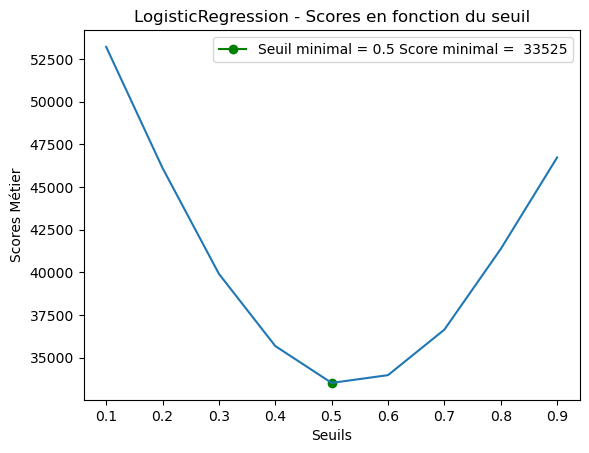

In [48]:
# prédictions des probabilités pour la classe positive avec les meilleurs hyperparamètres
probas_pred_test_rl = best_model_reglog.predict_proba(X_test_sc)[:, 1] 
# définir les seuils
thresholds = np.arange(0.1, 1.0, 0.1)
# liste des scores
scores = [] 
# calculer les scores pour chaque seuil 
for threshold in thresholds:
        # récupération des proba de prédcitions positives par rapport à chaque valeur du seuil
        y_pred_test = (probas_pred_test_rl >= threshold).astype(int) 
        # Fonction de calcul du coût total
        score_ = cout_metier(y_test, y_pred_test)  
        scores.append(score_)

# récupérer le score minimal et son seuil associé pour l'afficher
score_min = min(scores)
seuil_min = thresholds[scores.index(score_min)]

# afficher le graphique
plt.plot(seuil_min, score_min, marker= 'o', color = 'green', 
         label= f'Seuil minimal = {round(seuil_min, 2)} Score minimal =  {score_min}')
plt.plot(thresholds, scores)
plt.xlabel('Seuils')
plt.ylabel('Scores Métier')
plt.title('LogisticRegression - Scores en fonction du seuil')
plt.legend()
plt.show()

* affinage du seuil


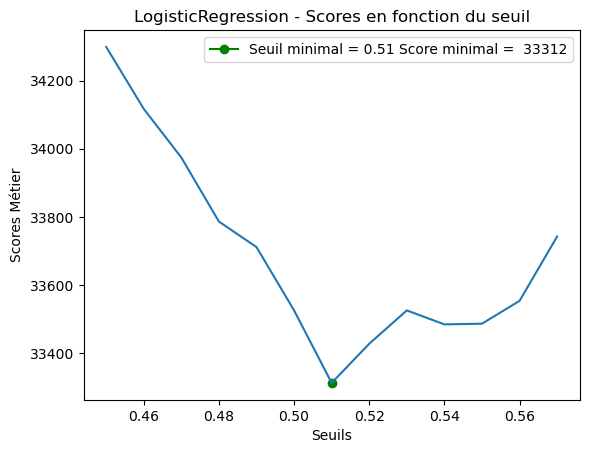

In [49]:
# définir les seuils
thresholds = np.arange(seuil_min-0.05, seuil_min+0.07, 0.01)
# liste des scores
scores = [] 
# calculer les scores pour chaque seuil 
for threshold in thresholds:
        # récupération des proba de prédcitions positives par rapport à chaque valeur du seuil
        y_pred_test = (probas_pred_test_rl >= threshold).astype(int) 
        # Fonction de calcul du coût total
        score_ = cout_metier(y_test, y_pred_test)  
        scores.append(score_)

# récupérer le score minimal et son seuil associé pour l'afficher
score_min_rl = min(scores)
seuil_min_rl = thresholds[scores.index(score_min_rl)]

# afficher le graphique
plt.plot(seuil_min_rl, score_min_rl, marker= 'o', color = 'green', 
         label= f'Seuil minimal = {round(seuil_min_rl, 2)} Score minimal =  {score_min_rl}')
plt.plot(thresholds, scores)
plt.xlabel('Seuils')
plt.ylabel('Scores Métier')
plt.title('LogisticRegression - Scores en fonction du seuil')
plt.legend()
plt.show()
         


**ÉVALUATION DU CLASSIFIER POUR LE SEUIL MINIMAL**

* observons la matrice de confusion ainsi que la courbe ROC correspondant au score et seuil minimaux

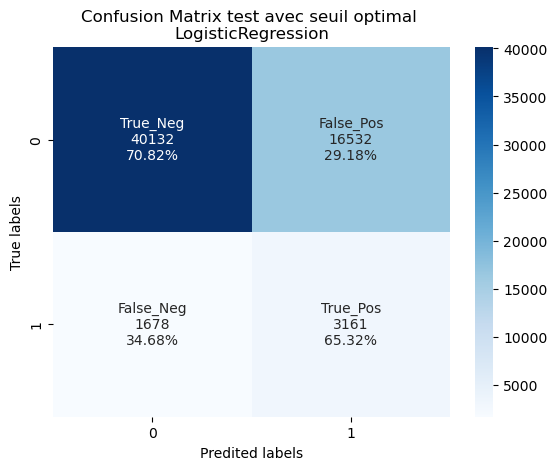

In [50]:
# predictions sur le jeu de test avec le seuil minimal
y_pred_test_opti_rl = (probas_pred_test_rl >= seuil_min_rl).astype(int) 
# matrice de confusion
c_m_test_opti_rl = confusion_matrix(y_test, y_pred_test_opti_rl)
graph_conf_matrix_binary(c_m_test_opti_rl, 'test avec seuil optimal \nLogisticRegression')

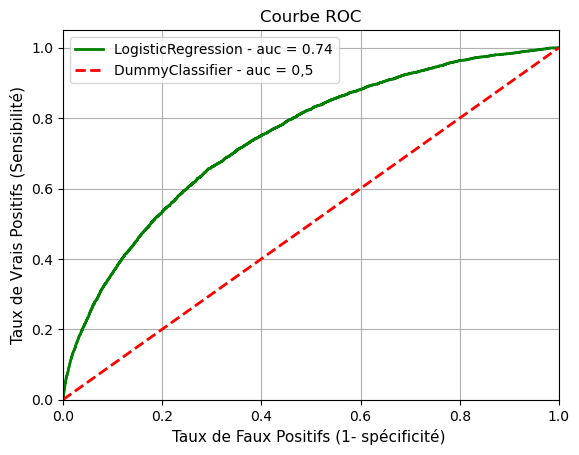

In [51]:
fpr_rl, tpr_rl, auc_rl  = graph_roc_auc(y_test, probas_pred_test_rl, 'LogisticRegression')

# COMPARAISON DES COURBES ROC ET DE L'AUC DES 2 MODÈLES

<function matplotlib.pyplot.show(close=None, block=None)>

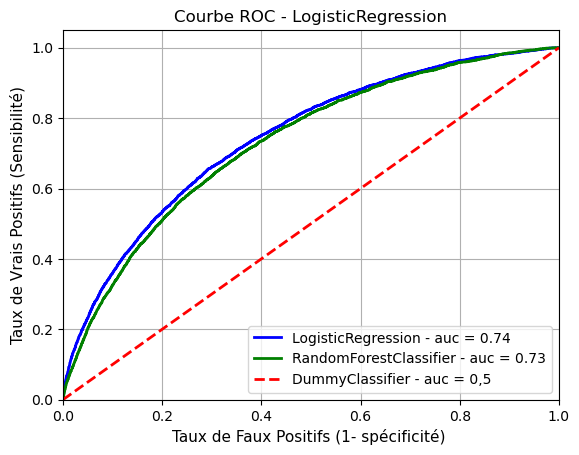

In [52]:
plt.plot(fpr_rl, tpr_rl, color='blue', lw=2, label= f'LogisticRegression - auc = {round(auc_rl,2)}')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label= f'RandomForestClassifier - auc = {round(auc_rf,2)}') # pour rappel
plt.plot([0, 1], [0, 1], ls = '--', lw=2, color='red', label='DummyClassifier - auc = 0,5')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (1- spécificité) ', fontsize=11)
plt.ylabel('Taux de Vrais Positifs (Sensibilité)', fontsize=11)
plt.title('Courbe ROC - LogisticRegression')
plt.grid(True)
plt.legend()
plt.show

# SELECTION DU MODÈLE
* La régression logistique devance de peu le RandomForestClassifier en terme de métriques traditionnelles (Courbe ROC, AUC, excepté pour le taux de Faux Positifs) et de score métier (34526 pour la RF et 33312 pour la RegLog).
* Le temps de calcul est aussi en faveur de la régression logistique.
* Tout indique que la régression logistique est notre meilleur modèle.
* nous allons affiner l'hyperparamètre 'C', qui contrôle la force de régularisation. Une valeur élevée de 'C' entraîne une régularisation plus faible, augmentant le risque de d'overfitting.

## RÉGRESSION LOGISTIQUE - Affinage 'C'

In [53]:
# création d'un pipeline d'oversampling pour diminuer le déséquilibre entre les classes négatives et positives
pipeline_reglog = Pipeline([('smote', SMOTE(random_state = 42, sampling_strategy='minority', k_neighbors=3)),
     ('LogisticRegression', LogisticRegression(verbose = 1, max_iter= 150,random_state = 42))
    ])

In [55]:
c__ = list(np.arange(10-5, 10+2, 1))
param_grid_rl = {'LogisticRegression__C' : c__ ,
                  'LogisticRegression__n_jobs' : [-1], 
                 }
# Créer un GridSearchCV avec le scorer personnalisé
grid_search_rl = GridSearchCV(estimator=pipeline_reglog,
                           param_grid=param_grid_rl, 
                           scoring=score_metier, 
                           cv=5 #nombre de plis
                          )

In [56]:
####### X_train_sc.shape =  (246008, 137) y_train.shape =  (246008,) 
####### X_test_sc.shape =  (61503, 137) y_test.shape =  (61503,)
start = time.time()
grid_search_rl.fit(X_train_sc, y_train)
end = time.time()
duree = str(timedelta(seconds=(end-start)))
print('durée d\'entraîneemnt : ', duree)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07325D+05    |proj g|=  2.80525D+02

At iterate  100    f=  2.06842D+05    |proj g|=  1.90798D+02

At iterate  150    f=  2.06672D+05    |proj g|=  3.03477D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   3.035D+02   2.067D+05
  F =   206671.56609172144     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07244D+05    |proj g|=  3.96577D+02

At iterate  100    f=  2.06782D+05    |proj g|=  2.20204D+02

At iterate  150    f=  2.06620D+05    |proj g|=  1.87291D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.873D+02   2.066D+05
  F =   206620.01976718247     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07045D+05    |proj g|=  4.75718D+02

At iterate  100    f=  2.06570D+05    |proj g|=  4.64759D+02

At iterate  150    f=  2.06390D+05    |proj g|=  2.07858D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   2.079D+02   2.064D+05
  F =   206389.63594046456     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07134D+05    |proj g|=  3.66492D+02

At iterate  100    f=  2.06555D+05    |proj g|=  3.43706D+02

At iterate  150    f=  2.06392D+05    |proj g|=  1.52053D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   1.521D+02   2.064D+05
  F =   206391.60262023038     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07018D+05    |proj g|=  5.33127D+02

At iterate  100    f=  2.06506D+05    |proj g|=  2.90978D+02

At iterate  150    f=  2.06283D+05    |proj g|=  2.28132D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   2.281D+02   2.063D+05
  F =   206283.46184558645     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07325D+05    |proj g|=  2.97493D+02

At iterate  100    f=  2.06845D+05    |proj g|=  2.88931D+02

At iterate  150    f=  2.06667D+05    |proj g|=  2.54365D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   2.544D+02   2.067D+05
  F =   206666.52510327697     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07247D+05    |proj g|=  2.90572D+02

At iterate  100    f=  2.06779D+05    |proj g|=  4.21010D+02

At iterate  150    f=  2.06617D+05    |proj g|=  2.18545D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   2.185D+02   2.066D+05
  F =   206617.29639577109     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07044D+05    |proj g|=  4.69066D+02

At iterate  100    f=  2.06541D+05    |proj g|=  2.81797D+02

At iterate  150    f=  2.06387D+05    |proj g|=  2.33093D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   2.331D+02   2.064D+05
  F =   206386.85928824628     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07134D+05    |proj g|=  3.66396D+02

At iterate  100    f=  2.06561D+05    |proj g|=  2.68808D+02

At iterate  150    f=  2.06377D+05    |proj g|=  2.19467D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   2.195D+02   2.064D+05
  F =   206377.41382290373     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07019D+05    |proj g|=  4.55397D+02

At iterate  100    f=  2.06512D+05    |proj g|=  3.04636D+02

At iterate  150    f=  2.06292D+05    |proj g|=  4.58308D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   4.583D+02   2.063D+05
  F =   206291.88981618988     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07324D+05    |proj g|=  3.36161D+02

At iterate  100    f=  2.06867D+05    |proj g|=  2.70622D+02

At iterate  150    f=  2.06695D+05    |proj g|=  2.07070D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   2.071D+02   2.067D+05
  F =   206694.78959853039     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07251D+05    |proj g|=  3.32784D+02

At iterate  100    f=  2.06786D+05    |proj g|=  3.78884D+02

At iterate  150    f=  2.06622D+05    |proj g|=  2.31396D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    160      1     0     0   2.314D+02   2.066D+05
  F =   206621.83185199750     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07044D+05    |proj g|=  4.68143D+02

At iterate  100    f=  2.06567D+05    |proj g|=  4.72731D+02

At iterate  150    f=  2.06398D+05    |proj g|=  2.03669D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   2.037D+02   2.064D+05
  F =   206397.77153702427     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66339D+02

At iterate  100    f=  2.06555D+05    |proj g|=  3.70364D+02

At iterate  150    f=  2.06372D+05    |proj g|=  2.10643D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   2.106D+02   2.064D+05
  F =   206371.59339669711     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07020D+05    |proj g|=  4.24397D+02

At iterate  100    f=  2.06497D+05    |proj g|=  4.36637D+02

At iterate  150    f=  2.06282D+05    |proj g|=  2.35047D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   2.350D+02   2.063D+05
  F =   206282.19509109756     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07324D+05    |proj g|=  3.87494D+02

At iterate  100    f=  2.06859D+05    |proj g|=  3.11447D+02

At iterate  150    f=  2.06676D+05    |proj g|=  2.30521D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   2.305D+02   2.067D+05
  F =   206676.22671893126     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07252D+05    |proj g|=  3.47509D+02

At iterate  100    f=  2.06797D+05    |proj g|=  3.23203D+02

At iterate  150    f=  2.06627D+05    |proj g|=  2.36019D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   2.360D+02   2.066D+05
  F =   206627.31464910065     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07043D+05    |proj g|=  4.67953D+02

At iterate  100    f=  2.06547D+05    |proj g|=  4.95338D+02

At iterate  150    f=  2.06394D+05    |proj g|=  2.37210D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    160      1     0     0   2.372D+02   2.064D+05
  F =   206393.81568463039     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66300D+02

At iterate  100    f=  2.06549D+05    |proj g|=  4.64584D+02

At iterate  150    f=  2.06375D+05    |proj g|=  1.71878D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    163      1     0     0   1.719D+02   2.064D+05
  F =   206374.79957504524     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07020D+05    |proj g|=  4.08612D+02

At iterate  100    f=  2.06494D+05    |proj g|=  3.73252D+02

At iterate  150    f=  2.06290D+05    |proj g|=  1.77699D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   1.777D+02   2.063D+05
  F =   206289.81829288110     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07324D+05    |proj g|=  4.01559D+02

At iterate  100    f=  2.06848D+05    |proj g|=  2.98627D+02

At iterate  150    f=  2.06671D+05    |proj g|=  2.66190D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   2.662D+02   2.067D+05
  F =   206670.50794087074     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07252D+05    |proj g|=  3.61380D+02

At iterate  100    f=  2.06798D+05    |proj g|=  5.58445D+02

At iterate  150    f=  2.06615D+05    |proj g|=  2.47673D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   2.477D+02   2.066D+05
  F =   206615.07090026958     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07043D+05    |proj g|=  4.67864D+02

At iterate  100    f=  2.06555D+05    |proj g|=  2.67999D+02

At iterate  150    f=  2.06394D+05    |proj g|=  2.89307D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   2.893D+02   2.064D+05
  F =   206394.16853948814     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66272D+02

At iterate  100    f=  2.06548D+05    |proj g|=  4.06509D+02

At iterate  150    f=  2.06375D+05    |proj g|=  3.05665D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   3.057D+02   2.064D+05
  F =   206374.69071337004     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07021D+05    |proj g|=  3.99244D+02

At iterate  100    f=  2.06498D+05    |proj g|=  4.59612D+02

At iterate  150    f=  2.06291D+05    |proj g|=  1.19363D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   1.194D+02   2.063D+05
  F =   206290.52905460354     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07323D+05    |proj g|=  3.64282D+02

At iterate  100    f=  2.06854D+05    |proj g|=  2.15132D+02

At iterate  150    f=  2.06677D+05    |proj g|=  1.95274D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   1.953D+02   2.067D+05
  F =   206677.15073922515     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07252D+05    |proj g|=  3.63749D+02

At iterate  100    f=  2.06779D+05    |proj g|=  3.48586D+02

At iterate  150    f=  2.06608D+05    |proj g|=  1.70203D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   1.702D+02   2.066D+05
  F =   206608.38321312252     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07043D+05    |proj g|=  4.67798D+02

At iterate  100    f=  2.06542D+05    |proj g|=  2.74338D+02

At iterate  150    f=  2.06385D+05    |proj g|=  1.90586D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   1.906D+02   2.064D+05
  F =   206385.09322081390     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66252D+02

At iterate  100    f=  2.06563D+05    |proj g|=  4.00568D+02

At iterate  150    f=  2.06369D+05    |proj g|=  5.24662D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   5.247D+02   2.064D+05
  F =   206368.53720269853     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07021D+05    |proj g|=  3.93098D+02

At iterate  100    f=  2.06479D+05    |proj g|=  3.16993D+02

At iterate  150    f=  2.06271D+05    |proj g|=  1.92983D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   1.930D+02   2.063D+05
  F =   206270.63201719875     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07322D+05    |proj g|=  3.33495D+02

At iterate  100    f=  2.06860D+05    |proj g|=  5.74228D+02

At iterate  150    f=  2.06673D+05    |proj g|=  2.36585D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   2.366D+02   2.067D+05
  F =   206672.59811507718     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07240D+05    |proj g|=  4.07525D+02

At iterate  100    f=  2.06779D+05    |proj g|=  3.13408D+02

At iterate  150    f=  2.06613D+05    |proj g|=  2.41280D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   2.413D+02   2.066D+05
  F =   206612.55405074067     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07043D+05    |proj g|=  4.67747D+02

At iterate  100    f=  2.06566D+05    |proj g|=  4.83311D+02

At iterate  150    f=  2.06398D+05    |proj g|=  1.76114D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.761D+02   2.064D+05
  F =   206397.85373180182     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66235D+02

At iterate  100    f=  2.06568D+05    |proj g|=  3.83657D+02

At iterate  150    f=  2.06378D+05    |proj g|=  2.29182D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   2.292D+02   2.064D+05
  F =   206377.94832506575     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07021D+05    |proj g|=  3.88775D+02

At iterate  100    f=  2.06494D+05    |proj g|=  3.10604D+02

At iterate  150    f=  2.06284D+05    |proj g|=  2.75023D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    169      1     0     0   2.750D+02   2.063D+05
  F =   206284.19198322526     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07317D+05    |proj g|=  3.89446D+02

At iterate  100    f=  2.06856D+05    |proj g|=  4.48321D+02

At iterate  150    f=  2.06665D+05    |proj g|=  2.51303D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   2.513D+02   2.067D+05
  F =   206664.79032668247     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07241D+05    |proj g|=  3.89014D+02

At iterate  100    f=  2.06756D+05    |proj g|=  2.62508D+02

At iterate  150    f=  2.06592D+05    |proj g|=  1.81642D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   1.816D+02   2.066D+05
  F =   206592.03186685315     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07043D+05    |proj g|=  4.67710D+02

At iterate  100    f=  2.06551D+05    |proj g|=  2.85562D+02

At iterate  150    f=  2.06393D+05    |proj g|=  1.76917D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    166      1     0     0   1.769D+02   2.064D+05
  F =   206392.66802365301     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66222D+02

At iterate  100    f=  2.06561D+05    |proj g|=  3.43839D+02

At iterate  150    f=  2.06382D+05    |proj g|=  2.86060D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   2.861D+02   2.064D+05
  F =   206382.11552495562     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07021D+05    |proj g|=  3.85577D+02

At iterate  100    f=  2.06501D+05    |proj g|=  3.82596D+02

At iterate  150    f=  2.06288D+05    |proj g|=  1.58639D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   1.586D+02   2.063D+05
  F =   206287.69718064976     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07316D+05    |proj g|=  3.64832D+02

At iterate  100    f=  2.06852D+05    |proj g|=  2.26010D+02

At iterate  150    f=  2.06685D+05    |proj g|=  2.09611D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   2.096D+02   2.067D+05
  F =   206684.52428067935     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07242D+05    |proj g|=  3.68736D+02

At iterate  100    f=  2.06794D+05    |proj g|=  2.73152D+02

At iterate  150    f=  2.06626D+05    |proj g|=  1.35058D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   1.351D+02   2.066D+05
  F =   206626.24313195271     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07042D+05    |proj g|=  4.67683D+02

At iterate  100    f=  2.06555D+05    |proj g|=  2.78687D+02

At iterate  150    f=  2.06383D+05    |proj g|=  2.31163D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   2.312D+02   2.064D+05
  F =   206382.96622304659     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66212D+02

At iterate  100    f=  2.06558D+05    |proj g|=  3.36180D+02

At iterate  150    f=  2.06377D+05    |proj g|=  1.73106D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   1.731D+02   2.064D+05
  F =   206376.53587776949     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07021D+05    |proj g|=  3.83119D+02

At iterate  100    f=  2.06475D+05    |proj g|=  5.17834D+02

At iterate  150    f=  2.06273D+05    |proj g|=  1.88384D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   1.884D+02   2.063D+05
  F =   206273.05571947654     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13333D+05    |proj g|=  8.06129D+04


 This problem is unconstrained.



At iterate   50    f=  2.59367D+05    |proj g|=  9.95546D+02

At iterate  100    f=  2.58757D+05    |proj g|=  3.31110D+02

At iterate  150    f=  2.58543D+05    |proj g|=  3.09323D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   3.093D+02   2.585D+05
  F =   258543.38569339149     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
durée d'entraîneemnt :  0:11:47.572474


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   16.8s finished


In [60]:
# les meilleurs hyoerparamètres
best_params_reglog = grid_search_rl.best_params_
best_params_reglog

{'LogisticRegression__C': 7, 'LogisticRegression__n_jobs': -1}

In [61]:
# avec le meilleur modèle prédiction sur le jeu de test # PREDICT SUR TEST (ancien 38572)
best_model_reglog = grid_search_rl.best_estimator_
y_predict_test_rl = best_model_reglog.predict(X_test_sc)
# évaluer le modèle sur le jeu de test avec la métrique personnalisée métier
test_score_metier_reglog = cout_metier(y_test, y_predict_test_rl)
print('test_score_metier_reglog = ', test_score_metier_reglog)

test_score_metier_reglog =  33564


**CONCLUSION**
* nous trouvons une meilleure valeur pour 'C', C = 7.

# ANALYSE DE L'IMPORTANCE GLOBALE (modèle) ET DE L'IMPORTANCE DES VARIABLES LOCALE (client donné)



## IMPORTANCE GLOBALE DES VARIABLES 
* Pour faire cette analyse sur notre modèle sélectionné (avec les meilleurs hyperparamètres et le pipeline incluant l'oversampling), nous allons utilisé la librairie SHAP, spécialisée dans le calcul de l'importance des features.

In [62]:
# création d'un pipeline d'oversampling pour diminuer le déséquilibre entre les classes négatives et positives
pipeline_reglog = Pipeline([('smote', SMOTE(random_state = 42, sampling_strategy='minority', k_neighbors=3)),
     ('LogisticRegression', LogisticRegression(verbose = 1, max_iter= 150,random_state = 42))
    ])

In [63]:
c__ = [7]
param_grid_rl = {'LogisticRegression__C' : c__ ,
                  'LogisticRegression__n_jobs' : [-1], 
                 }
# Créer un GridSearchCV avec le scorer personnalisé
grid_search_rl = GridSearchCV(estimator=pipeline_reglog,
                           param_grid=param_grid_rl, 
                           scoring=score_metier, 
                           cv=5 #nombre de plis
                          )
grid_search_rl.fit(X_train_sc, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.45464D+04


 This problem is unconstrained.



At iterate   50    f=  2.07324D+05    |proj g|=  4.01559D+02

At iterate  100    f=  2.06848D+05    |proj g|=  2.98627D+02

At iterate  150    f=  2.06671D+05    |proj g|=  2.66190D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   2.662D+02   2.067D+05
  F =   206670.50794087074     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50666D+05    |proj g|=  6.41013D+04


 This problem is unconstrained.



At iterate   50    f=  2.07252D+05    |proj g|=  3.61380D+02

At iterate  100    f=  2.06798D+05    |proj g|=  5.58445D+02

At iterate  150    f=  2.06615D+05    |proj g|=  2.47673D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    164      1     0     0   2.477D+02   2.066D+05
  F =   206615.07090026958     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/anaconda3/envs/env_projet_4/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.45967D+04


 This problem is unconstrained.



At iterate   50    f=  2.07043D+05    |proj g|=  4.67864D+02

At iterate  100    f=  2.06555D+05    |proj g|=  2.67999D+02

At iterate  150    f=  2.06394D+05    |proj g|=  2.89307D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    162      1     0     0   2.893D+02   2.064D+05
  F =   206394.16853948814     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.48796D+04


 This problem is unconstrained.



At iterate   50    f=  2.07133D+05    |proj g|=  3.66272D+02

At iterate  100    f=  2.06548D+05    |proj g|=  4.06509D+02

At iterate  150    f=  2.06375D+05    |proj g|=  3.05665D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    165      1     0     0   3.057D+02   2.064D+05
  F =   206374.69071337004     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.50667D+05    |proj g|=  6.46845D+04


 This problem is unconstrained.



At iterate   50    f=  2.07021D+05    |proj g|=  3.99244D+02

At iterate  100    f=  2.06498D+05    |proj g|=  4.59612D+02

At iterate  150    f=  2.06291D+05    |proj g|=  1.19363D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    167      1     0     0   1.194D+02   2.063D+05
  F =   206290.52905460354     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          139     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13333D+05    |proj g|=  8.06129D+04

At iterate   50    f=  2.59367D+05    |proj g|=  9.95546D+02

At iterate  100    f=  2.58757D+05    |proj g|=  3.31110D+02

At iterate  150    f=  2.58543D+05    |proj g|=  3.09323D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  139    150    161      1     0     0   3.093D+02   2.585D+05
  F =   258543.38569339149     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   15.9s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(k_neighbors=3, random_state=42,
                                              sampling_strategy='minority')),
                                       ('LogisticRegression',
                                        LogisticRegression(max_iter=150,
                                                           random_state=42,
                                                           verbose=1))]),
             param_grid={'LogisticRegression__C': [7],
                         'LogisticRegression__n_jobs': [-1]},
             scoring=make_scorer(cout_metier, greater_is_better=False))

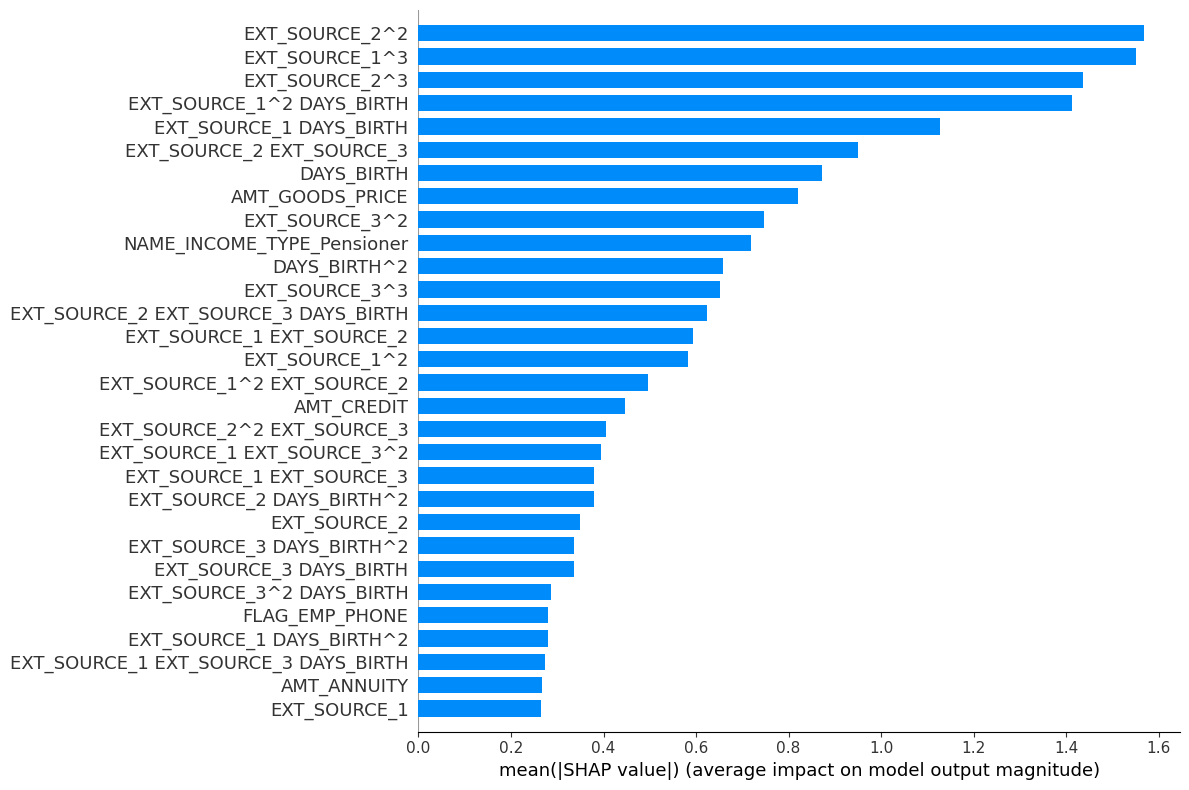

In [64]:
best_model_reglog = grid_search_rl.best_estimator_
#
model_shap = best_model_reglog.named_steps['LogisticRegression'] 
# créer l'explainer de shap sur notre modèle qui va calculer les features importances
explainer = shap.Explainer(model_shap, X_train_sc)
# calculer les deatures importances
shap_values = explainer.shap_values(X_train_sc)
# graphique des features importances pour le modèle
feature_names = data.columns[:-1]
shap.initjs()
shap.summary_plot(shap_values, X_train_sc, plot_type='bar', plot_size=(12, 8), feature_names=feature_names, max_display=30)
plt.show()

* on note que l'intégration des features polynomiales a été très pertinente pour l'apprentissage du modèle, elles représentent la majorité des features les plus instructives pour le modèle.

* a contrario, les features basées sur la coompréhension du domaine ne font pas partie des variables les plus pertinentes pour le modèle.

* la feature 'DAY_BIRTH' exprimant l'âge des contractants de crédit est la 6ème par ordre d'importance globale des variables pour le modèle, ce qui confirme l'importance de cette variable que nous avions vu lors de nos analyses en amont.

## IMPORTANCE LOCALE DES VARIABLES 

* sur le même principe d'analyse que l'importance globale avec SHAP, pour l'importance locale des variables, c'est à dire sur une instance du jeu de donnée, nous allons utiliser la librairie LIME (Local Interpretable Model-agnostic Explanations)

In [65]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(X_train_sc, mode='regression',training_labels=y_train, 
                                                   feature_names=feature_names, categorical_features=['TARGET'])
explanation = explainer_lime.explain_instance(X_test_sc[0], best_model_reglog.predict_proba)
explanation.show_in_notebook()

* La différence de couleur nous montre tout d’abord les features qui contribuent à augmenter la valeur prédite (en orange) et celles qui au contraire contribuent à la réduire (en bleu).

* On voit la valeur exacte de chaque feature de l’instance dans le tableau de droite, mais c’est surtout le graphe du milieu qui nous en apprend le plus sur la contribution de chaque feature à la prédiction. 

* Parmi les features contribuant le plus (positivement ou négativement) à la décision pour cet exemple, on retrouve peu ou prou les features polynomiales qui déjà contribuaient le plus à l'importance globale.
* On retrouve également DAYS_BIRTH (contribution négative) et NAME_INCOME_TYPE_Pensioner (contribution positive), déjà présentent dans les 11 features les plus apportant le plus d'information à la prise de décision du modèle (importance globale des variables)